In [2]:
!pip install pandas
!pip install tqdm
!pip install geopandas
!pip install autorank
!pip install scikit-learn==0.24.2

In [3]:
%matplotlib inline

import pandas as pd
import geopandas as gpd
from google.colab import drive
import logging
import matplotlib.pyplot as plt
import numpy as np
import scipy

logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO)

#evitar formatação em notação cientifica
pd.options.display.float_format = '{:.2f}'.format


drive.mount('/content/drive')
HOME = '/content/drive/MyDrive/TCC'

Mounted at /content/drive


# Dados
Os dados do Auxílio Emergencial, BPC e Bolsa Família são lidos facilmente pelo pandas, apenas explicitando que o separador utilizado no arquivo CSV é um ";"

In [ ]:
auxilio_emergencial = pd.read_csv(HOME + '/datasets/auxilio_emergencial.csv', sep=";")
bpc = pd.read_csv(HOME + '/datasets/bpc.csv', sep=";")
#só conseguimos obter os dados de bolsa família até dezembro de 2020
bolsa_familia = pd.read_csv(HOME + '/datasets/bolsa_familia.csv', sep=";")

Por outro lado, os dados de FPM estão em arquivos separados para cada mês, tem uma codificação diferente, que precisa ser explicitada ao usar o pandas na leitura dos arquivos. 
Ainda fazemos outros tratamentos para deixar os dados de FPM compatível com os demais, como: 
- Criar um coluna que agregue os decendios como um valor mensal;
- Criar uma coluna Mês/Ano que junte os dados que estão separados aqui, mas que nos demais dados estão juntos;
- Colocar os nomes dos municípios em caixa alta e alterar a grafia de alguns munícipios que não bate com os dados dos outros repasses.

---



In [ ]:
from os import listdir
fpm_home = HOME+'/datasets/fpm'
fpm = None
# os dados dos fpm estão em arquivos separados
# então é necessário juntar todos num dataframe só
for f in listdir(fpm_home):
  # há uma dificuldade pelo encoding diferente desse dado
  df = pd.read_csv(fpm_home+'/'+f, sep=';',encoding = "ISO-8859-1")
  # como há dados de todos os estados e de outras transferencias, é preciso filtrar para manter apenas o que é útil para a pesquisa
  fpm_data = df[ (df.UF == 'RJ') & (df['Transferência'] == 'FPM') ]
  try:
    fpm = pd.concat([fpm , fpm_data])
  except:
    fpm = fpm_data
# todos os outros dados tem a coluna Mês/Ano só esse tem os dados separados
# além disso, para deixar mais fácil o merge com os outros dados foi colocado o mês com 2 digítos
fpm['Mês/Ano'] = fpm.apply (lambda row: (str(row['Mês']) if row['Mês'] >= 10 else '0'+str(row['Mês']))+'/'+str(row['ANO']), axis=1)
fpm['Soma Decêndio'] = fpm.apply (lambda row: row['1º Decêndio'] + row['2º Decêndio'] + row['3º Decêndio'], axis=1)
# foi realizado upcase pra conseguir fazer o merge com os outros dados
fpm['Município'] = fpm['Município'].str.upper()
# esses municipios só tem o nome errado pra essa base
fpm['Município'] = fpm['Município'].replace(['PARATI'],'PARATY')
fpm['Município'] = fpm['Município'].replace(['ARMAÇÃO DE BÚZIOS'],'ARMAÇÃO DOS BÚZIOS')
fpm = fpm.reset_index(drop=True)

## Dados IBGE
Temos também os dados do IBGE. Os dados extraídos originalmente do site possuiam uma linha no inicio e no final do arquivo que não permitia que o dados fossem lido pelo pandas, então removemos manualmente essas duas linhas para ser possível ler com o pandas.



In [ ]:
dados_ibge = pd.read_csv(HOME + '/datasets/dados_ibge_rj.csv', sep=",")
dados_ibge

,Munic&iacute;pio [-],C&oacute;digo [-],Gent&iacute;lico [-],Prefeito [2021],&Aacute;rea Territorial - km&sup2; [2020],Popula&ccedil;&atilde;o estimada - pessoas [2020],Densidade demogr&aacute;fica - hab/km&sup2; [2010],Escolariza&ccedil;&atilde;o &lt;span&gt;6 a 14 anos&lt;/span&gt; - % [2010],IDHM &lt;span&gt;&Iacute;ndice de desenvolvimento humano municipal&lt;/span&gt; [2010],Mortalidade infantil - &oacute;bitos por mil nascidos vivos [2017],Receitas realizadas - R$ (&times;1000) [2017],Despesas empenhadas - R$ (&times;1000) [2017],PIB per capita - R$ [2018]
0,Angra dos Reis,3300100,angrense,FERNANDO ANT&Ocirc;NIO CECILIANO JORD&Atilde;O,813.420,207044,205.45,96.40,724,6.83,104.867.452.987,84.458.926.806,44590.88
1,Aperib&eacute;,3300159,aperibeense,RONALD DE C&Aacute;SSIO DAIBES MOREIRA,94.542,11901,107.92,96.70,692,27.40,N&atilde;o informado,N&atilde;o informado,15625.88
2,Araruama,3300209,araruamense,LIVIA SOARES BELLO DA SILVA,638.276,134293,175.55,98.30,718,10.66,31.677.086.324,31.478.634.675,20480.15
3,Areal,3300225,arealense,JOS&Eacute; AUGUSTO BERNARDES LIMA,110.724,12669,102.99,98.00,684,38.67,5.961.331.119,5.304.068.042,25200.29
4,Arma&ccedil;&atilde;o dos B&uacute;zios,3300233,buziano,ALEXANDRE DE OLIVEIRA MARTINS,70.977,34477,392.16,97.60,728,12.07,23.984.623.366,20.118.351.623,76723.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,Tr&ecirc;s Rios,3306008,trirriense,JOACIR BARBAGLIO PEREIRA,322.843,82142,237.42,97.90,725,11.73,26.432.376.642,25.087.214.429,48575.26
88,Valen&ccedil;a,3306107,valenciano,LUIZ FERNANDO FURTADO DA GRA&Ccedil;A,1.300.767,76869,55.06,97.70,738,9.73,18.632.290.479,16.722.620.187,33675.61
89,Varre-Sai,3306156,varresaiense,SILVESTRE JOSE GORINI,201.938,11106,49.85,96.80,659,12.82,5.310.092.583,4.282.187.075,17174.75
90,Vassouras,3306206,vassourense,SEVERINO ANANIAS DIAS FILHO,536.073,37083,63.94,98.80,714,10.22,13.702.958.211,12.240.591.477,26624.86


Podemos notar que os dados possuem uma codificação estranha, mas dessa vez não conseguimos passar um parametro na leitura do arquivo pelo pandas, permitindo a leitura correta dos dados. Precisamos fazer o parser das strings HTML.

In [ ]:
import io
import html

with open(HOME + '/datasets/dados_ibge_rj.csv') as f:
    s = f.read()
f = io.StringIO(html.unescape(s))
dados_ibge = pd.read_csv(f)
dados_ibge

,Município [-],Código [-],Gentílico [-],Prefeito [2021],Área Territorial - km² [2020],População estimada - pessoas [2020],Densidade demográfica - hab/km² [2010],Escolarização <span>6 a 14 anos</span> - % [2010],IDHM <span>Índice de desenvolvimento humano municipal</span> [2010],Mortalidade infantil - óbitos por mil nascidos vivos [2017],Receitas realizadas - R$ (×1000) [2017],Despesas empenhadas - R$ (×1000) [2017],PIB per capita - R$ [2018]
0,Angra dos Reis,3300100,angrense,FERNANDO ANTÔNIO CECILIANO JORDÃO,813.420,207044,205.45,96.40,724,6.83,104.867.452.987,84.458.926.806,44590.88
1,Aperibé,3300159,aperibeense,RONALD DE CÁSSIO DAIBES MOREIRA,94.542,11901,107.92,96.70,692,27.40,Não informado,Não informado,15625.88
2,Araruama,3300209,araruamense,LIVIA SOARES BELLO DA SILVA,638.276,134293,175.55,98.30,718,10.66,31.677.086.324,31.478.634.675,20480.15
3,Areal,3300225,arealense,JOSÉ AUGUSTO BERNARDES LIMA,110.724,12669,102.99,98.00,684,38.67,5.961.331.119,5.304.068.042,25200.29
4,Armação dos Búzios,3300233,buziano,ALEXANDRE DE OLIVEIRA MARTINS,70.977,34477,392.16,97.60,728,12.07,23.984.623.366,20.118.351.623,76723.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,Três Rios,3306008,trirriense,JOACIR BARBAGLIO PEREIRA,322.843,82142,237.42,97.90,725,11.73,26.432.376.642,25.087.214.429,48575.26
88,Valença,3306107,valenciano,LUIZ FERNANDO FURTADO DA GRAÇA,1.300.767,76869,55.06,97.70,738,9.73,18.632.290.479,16.722.620.187,33675.61
89,Varre-Sai,3306156,varresaiense,SILVESTRE JOSE GORINI,201.938,11106,49.85,96.80,659,12.82,5.310.092.583,4.282.187.075,17174.75
90,Vassouras,3306206,vassourense,SEVERINO ANANIAS DIAS FILHO,536.073,37083,63.94,98.80,714,10.22,13.702.958.211,12.240.591.477,26624.86


Ainda notamos alguns caracteres estranhos nos nomes das colunas e o nome dos municípiors em camelcase. Vamos fazer alguns pré-processamentos

In [ ]:
dados_ibge.rename(columns=lambda x: x.replace(' [-]','').replace('<span>','- ').replace('</span>',' '), inplace=True)
dados_ibge['Município'] = dados_ibge['Município'].str.upper()
dados_ibge

,Município,Código,Gentílico,Prefeito [2021],Área Territorial - km² [2020],População estimada - pessoas [2020],Densidade demográfica - hab/km² [2010],Escolarização - 6 a 14 anos - % [2010],IDHM - Índice de desenvolvimento humano municipal [2010],Mortalidade infantil - óbitos por mil nascidos vivos [2017],Receitas realizadas - R$ (×1000) [2017],Despesas empenhadas - R$ (×1000) [2017],PIB per capita - R$ [2018]
0,ANGRA DOS REIS,3300100,angrense,FERNANDO ANTÔNIO CECILIANO JORDÃO,813.420,207044,205.45,96.40,724,6.83,104.867.452.987,84.458.926.806,44590.88
1,APERIBÉ,3300159,aperibeense,RONALD DE CÁSSIO DAIBES MOREIRA,94.542,11901,107.92,96.70,692,27.40,Não informado,Não informado,15625.88
2,ARARUAMA,3300209,araruamense,LIVIA SOARES BELLO DA SILVA,638.276,134293,175.55,98.30,718,10.66,31.677.086.324,31.478.634.675,20480.15
3,AREAL,3300225,arealense,JOSÉ AUGUSTO BERNARDES LIMA,110.724,12669,102.99,98.00,684,38.67,5.961.331.119,5.304.068.042,25200.29
4,ARMAÇÃO DOS BÚZIOS,3300233,buziano,ALEXANDRE DE OLIVEIRA MARTINS,70.977,34477,392.16,97.60,728,12.07,23.984.623.366,20.118.351.623,76723.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,TRÊS RIOS,3306008,trirriense,JOACIR BARBAGLIO PEREIRA,322.843,82142,237.42,97.90,725,11.73,26.432.376.642,25.087.214.429,48575.26
88,VALENÇA,3306107,valenciano,LUIZ FERNANDO FURTADO DA GRAÇA,1.300.767,76869,55.06,97.70,738,9.73,18.632.290.479,16.722.620.187,33675.61
89,VARRE-SAI,3306156,varresaiense,SILVESTRE JOSE GORINI,201.938,11106,49.85,96.80,659,12.82,5.310.092.583,4.282.187.075,17174.75
90,VASSOURAS,3306206,vassourense,SEVERINO ANANIAS DIAS FILHO,536.073,37083,63.94,98.80,714,10.22,13.702.958.211,12.240.591.477,26624.86


## Dados PIB 2018

In [ ]:
pib_2018 = pd.read_csv(HOME + '/datasets/pib_rj_2018.csv', sep=";")
pib_2018['Município'] = pib_2018['Município'].str.upper()
pib_2018['Município'] = pib_2018['Município'].str.replace(' \(RJ\)','')
pib_2018

,Município,PIB (2018)
0,ANGRA DOS REIS,8936325
1,APERIBÉ,181448
2,ARARUAMA,2671410
3,AREAL,314273
4,ARMAÇÃO DOS BÚZIOS,2550287
...,...,...
87,TRÊS RIOS,3956601
88,VALENÇA,2564836
89,VARRE-SAI,187033
90,VASSOURAS,977186


# Dados de ICMS de 2020 e 2019

Os dados extraídos originalmente passaram primeiro por um processamento manual, onde células contendo informações de título como 'Governo do Estado do Rio de Janeiro', e a linha que separava os dados por região foram removidas. O arquivo resultante é o lido aqui como um csv.

In [ ]:
icms_2020 = pd.read_csv(HOME+'/datasets/icms_2020_modificado.csv', sep=';',encoding = "ISO-8859-1")
icms_2020

,Município,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro,Dezembro,Total Anual
0,ARARUAMA,"R$ 2.063.886,94","R$ 1.556.280,63","R$ 1.735.636,50","R$ 1.333.368,64","R$ 1.849.151,85","R$ 1.814.926,58","R$ 1.996.168,42","R$ 1.943.139,80","R$ 2.515.786,24","R$ 2.318.472,37","R$ 2.445.751,00","R$ 2.174.517,11","R$ 23.747.086,08"
1,ARMAÇÃO DOS BÚZIOS,"R$ 650.436,92","R$ 677.400,24","R$ 569.249,91","R$ 281.072,82","R$ 327.138,82","R$ 298.011,61","R$ 316.675,94","R$ 421.198,59","R$ 349.485,56","R$ 418.500,73","R$ 544.579,87","R$ 464.186,41","R$ 5.317.937,42"
2,ARRAIAL DO CABO,"R$ 278.131,00","R$ 270.669,61","R$ 231.316,25","R$ 172.449,53","R$ 147.884,34","R$ 192.509,13","R$ 141.749,93","R$ 157.039,97","R$ 158.708,25","R$ 157.464,82","R$ 159.389,78","R$ 187.640,51","R$ 2.254.953,12"
3,CABO FRIO,"R$ 5.265.748,44","R$ 4.011.183,02","R$ 3.348.951,56","R$ 1.928.653,65","R$ 3.205.321,00","R$ 2.879.085,17","R$ 5.295.967,59","R$ 4.856.657,93","R$ 5.236.438,51","R$ 4.523.758,56","R$ 5.589.750,64","R$ 5.498.503,22","R$ 51.640.019,29"
4,CACHOEIRAS DE MACACU,"R$ 2.213.240,74","R$ 3.585.562,73","R$ 8.288.873,45","R$ 835.552,95","R$ 2.513.105,40","R$ 2.791.598,41","R$ 854.092,84","R$ 923.288,97","R$ 983.766,46","R$ 1.314.417,58","R$ 1.458.155,61","R$ 1.077.807,69","R$ 26.839.462,83"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,SUMIDOURO,"R$ 374.034,02","R$ 438.510,78","R$ 377.351,57","R$ 414.669,05","R$ 355.913,60","R$ 376.324,84","R$ 370.961,88","R$ 428.631,10","R$ 464.885,96","R$ 575.455,45","R$ 498.840,67","R$ 442.405,24","R$ 5.117.984,16"
90,TERESÓPOLIS,"R$ 14.943.975,65","R$ 11.643.126,87","R$ 15.501.940,00","R$ 5.989.080,51","R$ 6.291.968,75","R$ 11.712.294,43","R$ 8.691.679,73","R$ 8.547.201,20","R$ 8.525.211,18","R$ 9.637.502,85","R$ 9.754.996,77","R$ 10.114.500,68","R$ 121.353.478,62"
91,TRAJANO DE MORAES,"R$ 2.079,37","R$ 1.001,98","R$ 2.595,03","R$ 954,78","R$ 2.663,03","R$ 5.146,67","R$ 8.108,03","R$ 6.922,30","R$ 9.428,56","R$ 6.122,21","R$ 8.353,55","R$ 3.485,14","R$ 56.860,65"
92,OUTROS,"R$ 599.833.657,99","R$ 502.338.156,23","R$ 492.293.510,17","R$ 446.897.518,19","R$ 338.921.452,38","R$ 392.615.800,84","R$ 535.185.842,63","R$ 596.251.805,93","R$ 617.593.982,06","R$ 619.710.118,40","R$ 646.639.301,31","R$ 639.802.457,79","R$ 6.428.083.603,92"


In [ ]:
icms_2019 = pd.read_csv(HOME+'/datasets/icms_2019_modificado.csv', sep=';',encoding = "ISO-8859-1")
icms_2019

,Município,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro,Dezembro,Total Anual
0,ARARUAMA,"R$ 1.680.762,44","R$ 1.234.234,95","R$ 1.251.259,27","R$ 1.502.526,13","R$ 1.472.140,67","R$ 1.426.590,00","R$ 1.554.140,82","R$ 1.750.788,73","R$ 1.726.839,14","R$ 1.434.312,58","R$ 1.788.835,24","R$ 1.427.296,10","R$ 18.249.726,07"
1,ARMAÇÃO DOS BÚZIOS,"R$ 588.880,35","R$ 703.604,50","R$ 377.881,90","R$ 519.919,50","R$ 395.434,70","R$ 322.968,82","R$ 369.269,04","R$ 491.312,75","R$ 443.328,34","R$ 300.291,25","R$ 460.497,16","R$ 658.995,44","R$ 5.632.383,75"
2,ARRAIAL DO CABO,"R$ 98.478,26","R$ 140.222,68","R$ 77.438,63","R$ 174.613,73","R$ 156.554,74","R$ 87.387,27","R$ 128.989,73","R$ 146.754,95","R$ 149.152,33","R$ 113.770,18","R$ 163.563,30","R$ 241.188,44","R$ 1.678.114,24"
3,CABO FRIO,"R$ 4.849.423,30","R$ 3.526.584,64","R$ 2.778.119,67","R$ 3.166.833,00","R$ 3.057.977,37","R$ 2.722.981,72","R$ 3.074.425,09","R$ 3.564.413,39","R$ 3.291.825,04","R$ 3.150.077,50","R$ 3.208.131,24","R$ 3.896.286,35","R$ 40.287.078,31"
4,CACHOEIRAS DE MACACU,"R$ 3.194.763,44","R$ 3.169.333,01","R$ 5.603.932,14","R$ 3.654.732,04","R$ 3.337.154,53","R$ 1.334.411,75","R$ 1.387.498,09","R$ 1.296.094,50","R$ 2.080.930,36","R$ 1.887.773,66","R$ 2.307.937,47","R$ 2.148.045,40","R$ 31.402.606,39"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,SUMIDOURO,"R$ 330.593,42","R$ 408.716,64","R$ 501.376,24","R$ 432.360,50","R$ 508.604,84","R$ 477.882,51","R$ 364.176,50","R$ 510.880,30","R$ 491.807,63","R$ 384.532,84","R$ 433.682,81","R$ 424.090,18","R$ 5.268.704,41"
90,TERESÓPOLIS,"R$ 11.475.239,17","R$ 8.861.268,62","R$ 8.729.071,25","R$ 10.423.800,35","R$ 8.438.394,14","R$ 9.870.029,43","R$ 8.783.766,57","R$ 8.697.734,16","R$ 9.766.634,05","R$ 11.539.526,77","R$ 11.579.030,39","R$ 11.191.840,49","R$ 119.356.335,39"
91,TRAJANO DE MORAES,"R$ 16.018,83","R$ 10.822,55","R$ 15.843,94","R$ 14.993,46","R$ 1.935,95","R$ 2.262,46","R$ 7.595,29","R$ 12.555,97","R$ 5.627,12","R$ 1.761,48","R$ 10.974,34","R$ 5.443,80","R$ 105.835,19"
92,OUTROS,"R$ 551.188.371,78","R$ 510.120.239,21","R$ 487.078.133,18","R$ 494.594.197,20","R$ 510.985.976,86","R$ 516.133.418,05","R$ 505.523.119,63","R$ 519.554.721,78","R$ 536.853.281,17","R$ 546.253.428,79","R$ 563.824.952,36","R$ 603.038.423,82","R$ 6.345.148.263,83"


## Concatenando dados de repasse

In [ ]:
dados = bpc[['Município','Mês/Ano']]
dados['BPC'] = bpc[['Valor Transferido']]

tmp = bolsa_familia[['Município','Mês/Ano']]
tmp['BOLSA FAMILIA'] = bolsa_familia[['Valor Transferido']]
dados = pd.merge(dados, tmp, on=['Município','Mês/Ano'])

tmp = auxilio_emergencial[['Município','Mês/Ano']]
tmp['AUXILIO EMERGENCIAL'] = auxilio_emergencial[['Valor Transferido']]
dados = pd.merge(dados, tmp, on=['Município','Mês/Ano'])

tmp = fpm[['Município', 'Mês/Ano']]
tmp['FPM'] = fpm[['Soma Decêndio']]
dados = pd.merge(dados, tmp, on=['Município','Mês/Ano'])

dados

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,Município,Mês/Ano,BPC,BOLSA FAMILIA,AUXILIO EMERGENCIAL,FPM
0,COMENDADOR LEVY GASPARIAN,12/2020,"78.375,00",127396,1040044,914002.63
1,COMENDADOR LEVY GASPARIAN,10/2020,"79.420,00",127436,862543,430504.81
2,COMENDADOR LEVY GASPARIAN,11/2020,"79.434,18",127437,1120382,570601.49
3,COMENDADOR LEVY GASPARIAN,09/2020,"80.465,00",127595,1314776,319936.06
4,COMENDADOR LEVY GASPARIAN,08/2020,"81.510,00",128108,1518000,397185.06
...,...,...,...,...,...,...
823,RIO DE JANEIRO,06/2020,"117.769.537,63",46919909,740594400,17304695.76
824,RIO DE JANEIRO,09/2020,"117.941.013,21",47913112,1149490204,15264153.44
825,RIO DE JANEIRO,10/2020,"118.194.948,75",47846856,760531244,20539389.07
826,RIO DE JANEIRO,11/2020,"118.393.839,01",47823576,983761199,27223404.55


Percebemos que as colunas referentes a valores possuem algumas discrepancias entre os diferentes repasses, vamos uniformizá-los

In [ ]:
#convertendo todas as colunas relativas a valor para float
dados.BPC = dados.BPC.str.replace('.','').str.replace(',','.').astype(float)
dados['BOLSA FAMILIA'] = dados['BOLSA FAMILIA'].astype(float)
dados['AUXILIO EMERGENCIAL'] = dados['AUXILIO EMERGENCIAL'].astype(float)
dados

,Município,Mês/Ano,BPC,BOLSA FAMILIA,AUXILIO EMERGENCIAL,FPM
0,COMENDADOR LEVY GASPARIAN,12/2020,78375.00,127396.00,1040044.00,914002.63
1,COMENDADOR LEVY GASPARIAN,10/2020,79420.00,127436.00,862543.00,430504.81
2,COMENDADOR LEVY GASPARIAN,11/2020,79434.18,127437.00,1120382.00,570601.49
3,COMENDADOR LEVY GASPARIAN,09/2020,80465.00,127595.00,1314776.00,319936.06
4,COMENDADOR LEVY GASPARIAN,08/2020,81510.00,128108.00,1518000.00,397185.06
...,...,...,...,...,...,...
823,RIO DE JANEIRO,06/2020,117769537.63,46919909.00,740594400.00,17304695.76
824,RIO DE JANEIRO,09/2020,117941013.21,47913112.00,1149490204.00,15264153.44
825,RIO DE JANEIRO,10/2020,118194948.75,47846856.00,760531244.00,20539389.07
826,RIO DE JANEIRO,11/2020,118393839.01,47823576.00,983761199.00,27223404.55


## Carregamento de dados geográficos para exibição de mapas

In [ ]:
# fonte de dados do mapa: https://caelum-online-public.s3.amazonaws.com/985-geopandas/01/Mapas.zip ou http://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2020/UFs/RJ/
mapa_rj = gpd.read_file(HOME+'/Mapas/RJ/33MUE250GC_SIR.shp')
mapa_rj.tail(10)

,ID,CD_GEOCODM,NM_MUNICIP,geometry
82,1550,3305604,SILVA JARDIM,"POLYGON ((-42.33565 -22.42905, -42.33522 -22.4..."
83,1551,3305703,SUMIDOURO,"POLYGON ((-42.73429 -22.21886, -42.73415 -22.2..."
84,1552,3305752,TANGUÁ,"POLYGON ((-42.75893 -22.71853, -42.75877 -22.7..."
85,1553,3305802,TERESÓPOLIS,"POLYGON ((-42.76504 -22.12872, -42.76460 -22.1..."
86,1554,3305901,TRAJANO DE MORAES,"POLYGON ((-42.24055 -22.03420, -42.24048 -22.0..."
87,1555,3306008,TRÊS RIOS,"POLYGON ((-43.13666 -22.10933, -43.13182 -22.1..."
88,1556,3306107,VALENÇA,"POLYGON ((-43.82120 -22.08844, -43.82101 -22.0..."
89,1557,3306156,VARRE-SAI,"POLYGON ((-41.82695 -20.84164, -41.82686 -20.8..."
90,1558,3306206,VASSOURAS,"POLYGON ((-43.61208 -22.30841, -43.61113 -22.3..."
91,1559,3306305,VOLTA REDONDA,"POLYGON ((-44.13912 -22.53062, -44.13878 -22.5..."


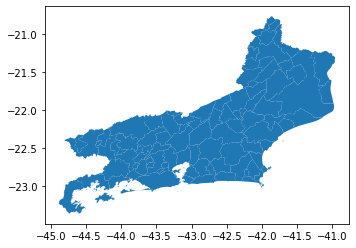

In [ ]:
mapa_rj.plot()

## Mais pré-processamento

In [ ]:
# há uma inconsistÊncia entre os municipios do dados do ibge e do governo
print(set(dados['Município'].unique()) - set(mapa_rj['NM_MUNICIP'].unique()))

print(sorted(dados['Município'].unique()))
print(sorted(mapa_rj['NM_MUNICIP'].unique()))

# descoberta a inconsistencia, foi feita a correção
dados['Município'] = dados['Município'].replace(['TRAJANO DE MORAIS'],'TRAJANO DE MORAES')

{'TRAJANO DE MORAIS'}
['ANGRA DOS REIS', 'APERIBÉ', 'ARARUAMA', 'AREAL', 'ARMAÇÃO DOS BÚZIOS', 'ARRAIAL DO CABO', 'BARRA DO PIRAÍ', 'BARRA MANSA', 'BELFORD ROXO', 'BOM JARDIM', 'BOM JESUS DO ITABAPOANA', 'CABO FRIO', 'CACHOEIRAS DE MACACU', 'CAMBUCI', 'CAMPOS DOS GOYTACAZES', 'CANTAGALO', 'CARAPEBUS', 'CARDOSO MOREIRA', 'CARMO', 'CASIMIRO DE ABREU', 'COMENDADOR LEVY GASPARIAN', 'CONCEIÇÃO DE MACABU', 'CORDEIRO', 'DUAS BARRAS', 'DUQUE DE CAXIAS', 'ENGENHEIRO PAULO DE FRONTIN', 'GUAPIMIRIM', 'IGUABA GRANDE', 'ITABORAÍ', 'ITAGUAÍ', 'ITALVA', 'ITAOCARA', 'ITAPERUNA', 'ITATIAIA', 'JAPERI', 'LAJE DO MURIAÉ', 'MACAÉ', 'MACUCO', 'MAGÉ', 'MANGARATIBA', 'MARICÁ', 'MENDES', 'MESQUITA', 'MIGUEL PEREIRA', 'MIRACEMA', 'NATIVIDADE', 'NILÓPOLIS', 'NITERÓI', 'NOVA FRIBURGO', 'NOVA IGUAÇU', 'PARACAMBI', 'PARATY', 'PARAÍBA DO SUL', 'PATY DO ALFERES', 'PETRÓPOLIS', 'PINHEIRAL', 'PIRAÍ', 'PORCIÚNCULA', 'PORTO REAL', 'QUATIS', 'QUEIMADOS', 'QUISSAMÃ', 'RESENDE', 'RIO BONITO', 'RIO CLARO', 'RIO DAS FLORES', 

## Concatenação de dados de repasse e dados geográficos

In [ ]:
media_fpm_por_municipio = dados[['Município','Mês/Ano','FPM']].groupby(['Município']).mean()
media_bpc_por_municipio = dados[['Município','Mês/Ano','BPC']].groupby(['Município']).mean()
media_bolsa_por_municipio = dados[['Município','Mês/Ano','BOLSA FAMILIA']].groupby(['Município']).mean()
media_auxilio_por_municipio = dados[['Município','Mês/Ano','AUXILIO EMERGENCIAL']].groupby(['Município']).mean()

mapa_rj = mapa_rj.merge(media_fpm_por_municipio, left_on='NM_MUNICIP', right_on='Município')
mapa_rj = mapa_rj.merge(media_bpc_por_municipio, left_on='NM_MUNICIP', right_on='Município')
mapa_rj = mapa_rj.merge(media_bolsa_por_municipio, left_on='NM_MUNICIP', right_on='Município')
mapa_rj = mapa_rj.merge(media_auxilio_por_municipio, left_on='NM_MUNICIP', right_on='Município')
mapa_rj = mapa_rj.merge(dados_ibge, left_on='NM_MUNICIP', right_on='Município')

mapa_rj

,ID,CD_GEOCODM,NM_MUNICIP,geometry,FPM,BPC,BOLSA FAMILIA,AUXILIO EMERGENCIAL,Município,Código,Gentílico,Prefeito [2021],Área Territorial - km² [2020],População estimada - pessoas [2020],Densidade demográfica - hab/km² [2010],Escolarização - 6 a 14 anos - % [2010],IDHM - Índice de desenvolvimento humano municipal [2010],Mortalidade infantil - óbitos por mil nascidos vivos [2017],Receitas realizadas - R$ (×1000) [2017],Despesas empenhadas - R$ (×1000) [2017],PIB per capita - R$ [2018]
0,1468,3300100,ANGRA DOS REIS,"MULTIPOLYGON (((-44.33208 -23.02384, -44.33221...",4413445.12,3252821.51,2222303.22,29438076.67,ANGRA DOS REIS,3300100,angrense,FERNANDO ANTÔNIO CECILIANO JORDÃO,813.420,207044,205.45,96.40,724,6.83,104.867.452.987,84.458.926.806,44590.88
1,1469,3300159,APERIBÉ,"POLYGON ((-42.08950 -21.62893, -42.08912 -21.6...",674895.68,172080.00,125623.22,1827344.22,APERIBÉ,3300159,aperibeense,RONALD DE CÁSSIO DAIBES MOREIRA,94.542,11901,107.92,96.70,692,27.40,Não informado,Não informado,15625.88
2,1470,3300209,ARARUAMA,"POLYGON ((-42.22526 -22.59253, -42.22521 -22.5...",3037030.48,3873568.67,2083571.89,26123382.11,ARARUAMA,3300209,araruamense,LIVIA SOARES BELLO DA SILVA,638.276,134293,175.55,98.30,718,10.66,31.677.086.324,31.478.634.675,20480.15
3,1471,3300225,AREAL,"POLYGON ((-43.16007 -22.20005, -43.16003 -22.1...",674895.68,261604.17,170855.56,2243495.89,AREAL,3300225,arealense,JOSÉ AUGUSTO BERNARDES LIMA,110.724,12669,102.99,98.00,684,38.67,5.961.331.119,5.304.068.042,25200.29
4,1472,3300233,ARMAÇÃO DOS BÚZIOS,"MULTIPOLYGON (((-41.98427 -22.74458, -41.98296...",1349791.33,652906.00,306118.78,9744939.11,ARMAÇÃO DOS BÚZIOS,3300233,buziano,ALEXANDRE DE OLIVEIRA MARTINS,70.977,34477,392.16,97.60,728,12.07,23.984.623.366,20.118.351.623,76723.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,1555,3306008,TRÊS RIOS,"POLYGON ((-43.13666 -22.10933, -43.13182 -22.1...",2362134.82,1242999.83,1190230.22,12699591.44,TRÊS RIOS,3306008,trirriense,JOACIR BARBAGLIO PEREIRA,322.843,82142,237.42,97.90,725,11.73,26.432.376.642,25.087.214.429,48575.26
88,1556,3306107,VALENÇA,"POLYGON ((-43.82120 -22.08844, -43.82101 -22.0...",2193410.91,1659844.14,1063391.11,11058364.22,VALENÇA,3306107,valenciano,LUIZ FERNANDO FURTADO DA GRAÇA,1.300.767,76869,55.06,97.70,738,9.73,18.632.290.479,16.722.620.187,33675.61
89,1557,3306156,VARRE-SAI,"POLYGON ((-41.82695 -20.84164, -41.82686 -20.8...",674895.68,222706.36,172136.56,1918470.00,VARRE-SAI,3306156,varresaiense,SILVESTRE JOSE GORINI,201.938,11106,49.85,96.80,659,12.82,5.310.092.583,4.282.187.075,17174.75
90,1558,3306206,VASSOURAS,"POLYGON ((-43.61208 -22.30841, -43.61113 -22.3...",1349791.33,1123990.37,305963.56,5594676.89,VASSOURAS,3306206,vassourense,SEVERINO ANANIAS DIAS FILHO,536.073,37083,63.94,98.80,714,10.22,13.702.958.211,12.240.591.477,26624.86


# Análise e Exploração dos Dados

## Gráfico ICMS x AE

In [ ]:
def processa_icms(icms):
  total_icms_mes = icms.iloc[-1:] #ultima linha é a soma total de icms por mês
  total_icms_mes = total_icms_mes.loc[:, total_icms_mes.columns != 'Município'] # a primeira coluna são os nomes dos municípios
  total_icms_mes = total_icms_mes.loc[:, total_icms_mes.columns != 'Total Anual'] # a ultima coluna é o total do ano
  total_icms_mes = total_icms_mes.T.rename(columns={93: "Total Arrecadado"}).reset_index().rename(columns={'index': "Mês"}) #transformar as colunas com meses em linhas e renomear a linha que usando um indice pelo texto
  total_icms_mes['Total Arrecadado'] = total_icms_mes['Total Arrecadado'].apply(lambda x: float(x.replace('R$ ','').replace('.','').replace(',','.')))
  return total_icms_mes

total_icms_2020_mes = processa_icms(icms_2020)

In [ ]:
ae_mes = auxilio_emergencial.groupby(['Mês/Ano']).sum().reset_index() # agrupo todos os repasses de AE por mÊs e somo
ae_mes = ae_mes[1:] # Descarto o primeiro registro pq é relativo a janeiro de 2021

INT_TO_MES = {4: 'Abril',5:'Maio',6: 'Junho',7:'Julho',8:'Agosto',9:'Setembro',10:'Outubro',11:'Novembro',12:'Dezembro'}

ae_mes['Mês'] = ae_mes['Mês/Ano'].apply(lambda x: INT_TO_MES[int(x.split('/')[0])])#crio uma nova coluna com os meses por extenso
ae_mes['Valor Transferido'] = ae_mes['Valor Transferido'].astype(float)
ae_mes

,Mês/Ano,Valor Transferido,Mês
1,04/2020,2757376200.00,Abril
2,05/2020,3401640600.00,Maio
3,06/2020,2158593600.00,Junho
4,07/2020,3571626000.00,Julho
5,08/2020,3173173800.00,Agosto
6,09/2020,3010164929.00,Setembro
7,10/2020,1998948825.00,Outubro
8,11/2020,2574479627.00,Novembro
9,12/2020,2293955616.00,Dezembro


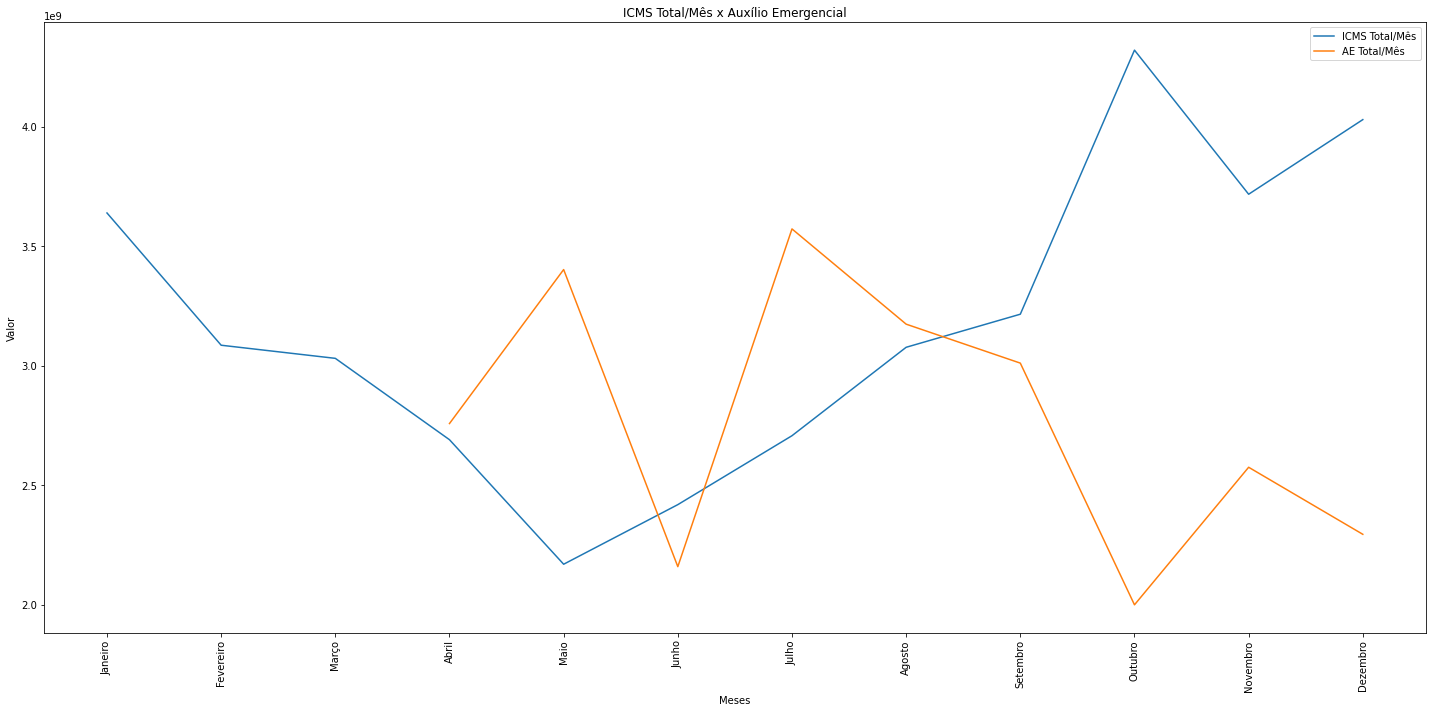

In [ ]:
fig = plt.figure(figsize=(20, 10))
plt.subplot(1, 1, 1)
plt.title('ICMS Total/Mês x Auxílio Emergencial')
plt.plot(total_icms_2020_mes['Mês'], total_icms_2020_mes['Total Arrecadado'],
          label='ICMS Total/Mês')
plt.plot(ae_mes['Mês'], ae_mes['Valor Transferido'],
          label='AE Total/Mês')
plt.legend(loc='upper right')
plt.xlabel('Meses')
plt.xticks(rotation='90')
plt.ylabel('Valor')
fig.tight_layout()
plt.show()

## Gráfico ICMS 2020 x 2019

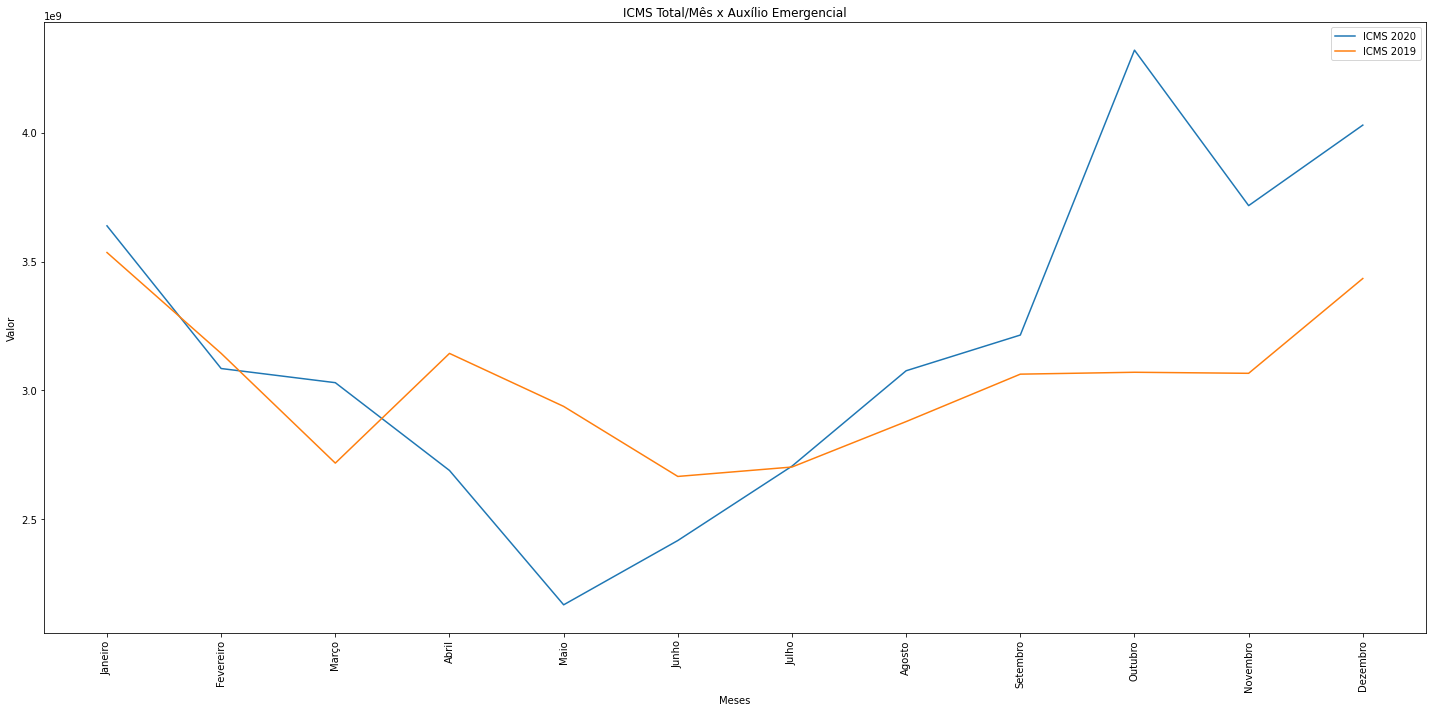

In [ ]:
total_icms_2019_mes = processa_icms(icms_2019)

fig = plt.figure(figsize=(20, 10))
plt.subplot(1, 1, 1)
plt.title('ICMS Total/Mês x Auxílio Emergencial')
plt.plot(total_icms_2020_mes['Mês'], total_icms_2020_mes['Total Arrecadado'],
          label='ICMS 2020')
plt.plot(total_icms_2019_mes['Mês'], total_icms_2019_mes['Total Arrecadado'],
          label='ICMS 2019')
plt.legend(loc='upper right')
plt.xlabel('Meses')
plt.xticks(rotation='90')
plt.ylabel('Valor')
fig.tight_layout()
plt.show()

## Gráfico IDH x AE e PIB x AE

Ainda nas análises preliminares, não foi possível fazer um gráfico com os três indicadores de uma vez por conta da escala de valores ser muito diferente.

In [ ]:
ibge_idh = dados_ibge[dados_ibge.filter(regex='Município|IDH').columns] # seleção das colunas de interesse
ibge_idh = ibge_idh.rename(columns={"IDHM - Índice de desenvolvimento humano municipal  [2010]": "IDHM (2010)"})
ibge_idh

,Município,IDHM (2010)
0,ANGRA DOS REIS,724
1,APERIBÉ,692
2,ARARUAMA,718
3,AREAL,684
4,ARMAÇÃO DOS BÚZIOS,728
...,...,...
87,TRÊS RIOS,725
88,VALENÇA,738
89,VARRE-SAI,659
90,VASSOURAS,714


In [ ]:
ae_total_municipio = auxilio_emergencial[auxilio_emergencial['Mês/Ano'] != '01/2021'][['Município','Valor Transferido']]
ae_total_municipio = ae_total_municipio.groupby(['Município']).sum().reset_index()
ae_total_municipio['Valor Transferido'] = ae_total_municipio['Valor Transferido'].astype(float)
ae_total_municipio

,Município,Valor Transferido
0,ANGRA DOS REIS,264942690.00
1,APERIBÉ,16446098.00
2,ARARUAMA,235110439.00
3,AREAL,20191463.00
4,ARMAÇÃO DOS BÚZIOS,87704452.00
...,...,...
87,TRÊS RIOS,114296323.00
88,VALENÇA,99525278.00
89,VARRE-SAI,17266230.00
90,VASSOURAS,50352092.00


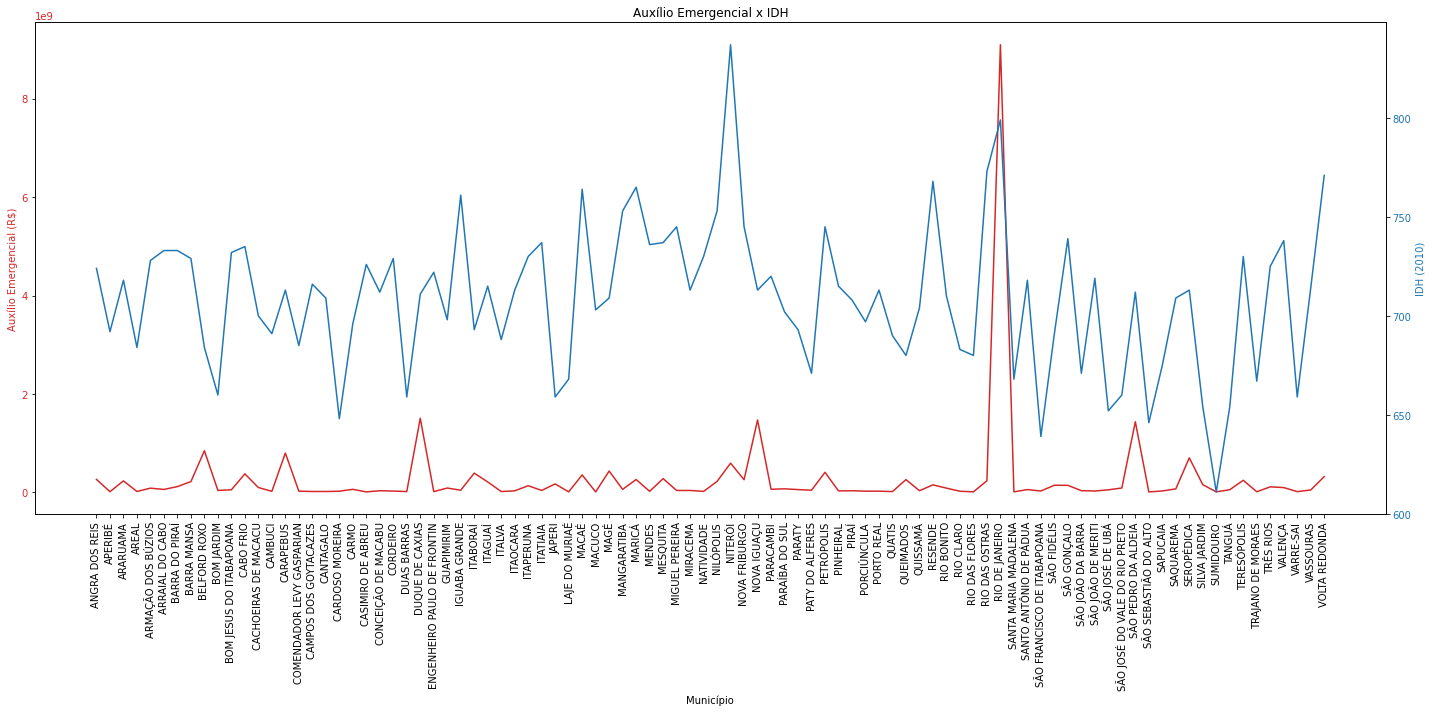

In [ ]:
fig, ax1 = plt.subplots()
fig.set_size_inches(20, 10)
plt.xticks(rotation='90')

color = 'tab:red'
ax1.set_xlabel('Município')
ax1.set_ylabel('Auxílio Emergencial (R$)', color=color)
ax1.plot(ae_total_municipio['Município'], ae_total_municipio['Valor Transferido'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('IDH (2010)', color=color)  # we already handled the x-label with ax1
ax2.plot(ibge_idh['Município'], ibge_idh['IDHM (2010)'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Auxílio Emergencial x IDH')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

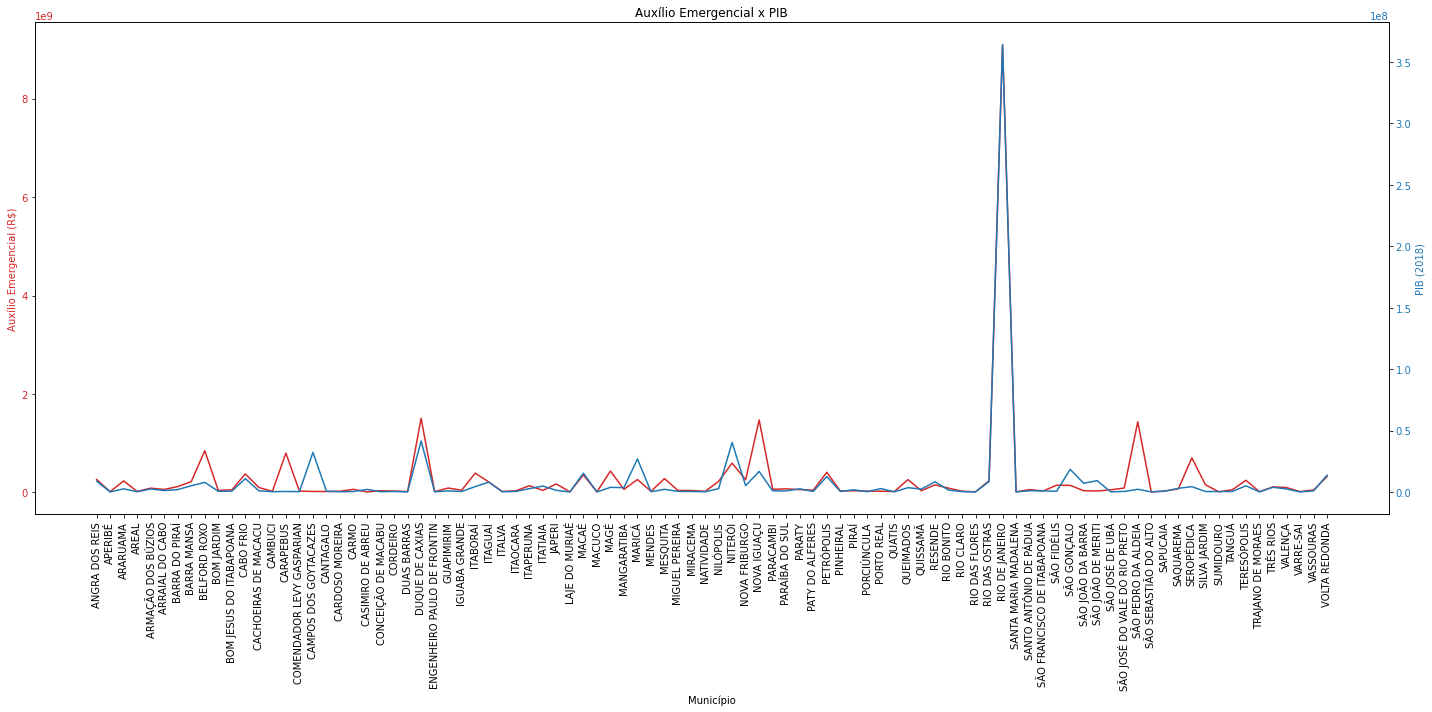

In [ ]:
fig, ax1 = plt.subplots()
fig.set_size_inches(20, 10)
plt.xticks(rotation='90')

color = 'tab:red'
ax1.set_xlabel('Município')
ax1.set_ylabel('Auxílio Emergencial (R$)', color=color)
ax1.plot(ae_total_municipio['Município'], ae_total_municipio['Valor Transferido'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('PIB (2018)', color=color)  # we already handled the x-label with ax1
ax2.plot(pib_2018['Município'], pib_2018['PIB (2018)'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Auxílio Emergencial x PIB')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Mapas por tipo de repasse

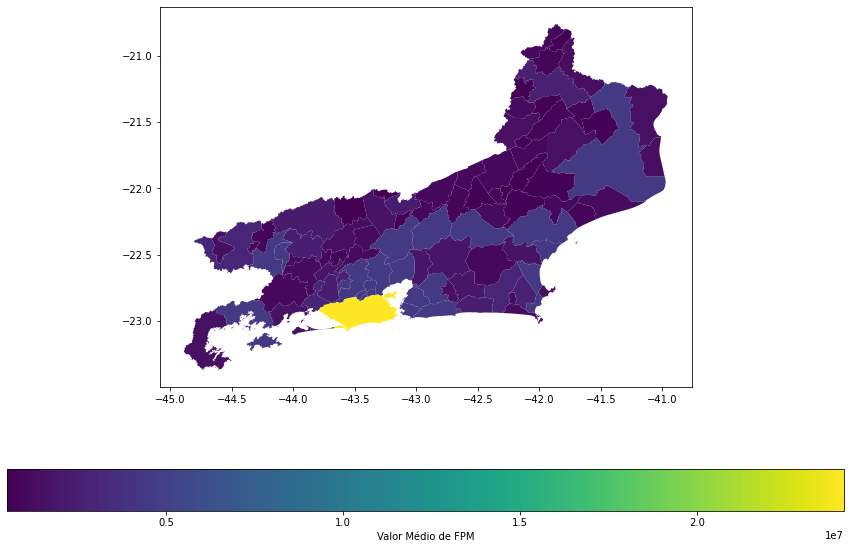

In [ ]:
mapa_rj.plot(column='FPM', legend=True,
             legend_kwds={'label': "Valor Médio de FPM",
                           'orientation': "horizontal"}, figsize=(15,10))

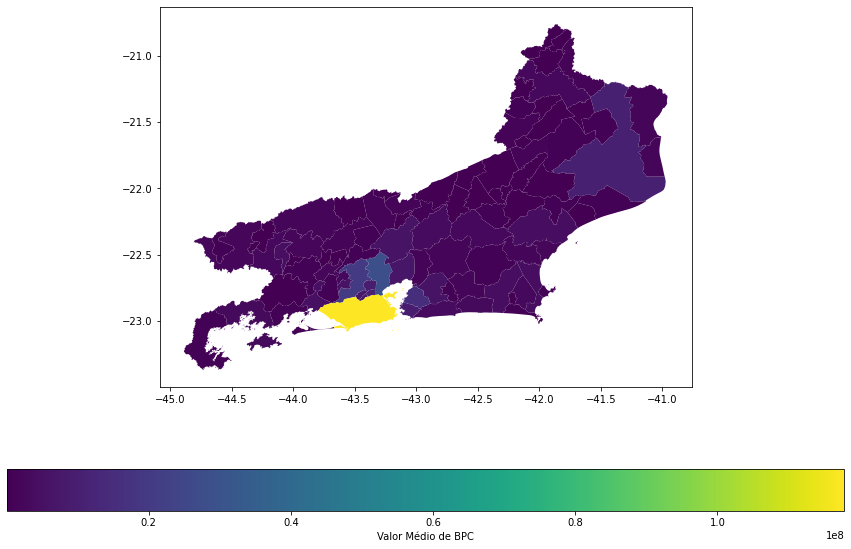

In [ ]:
mapa_rj.plot(column='BPC', legend=True,
             legend_kwds={'label': "Valor Médio de BPC",
                           'orientation': "horizontal"}, figsize=(15,10))

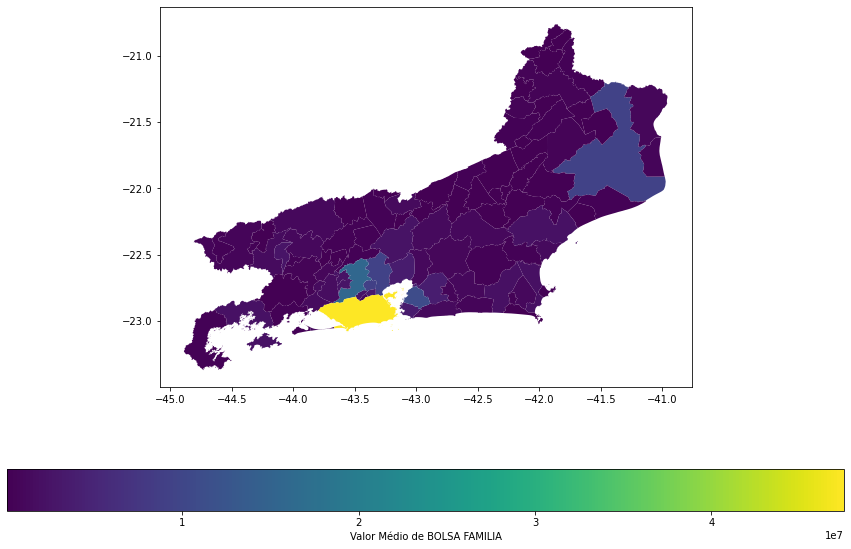

In [ ]:
mapa_rj.plot(column='BOLSA FAMILIA', legend=True,
             legend_kwds={'label': "Valor Médio de BOLSA FAMILIA",
                           'orientation': "horizontal"}, figsize=(15,10))

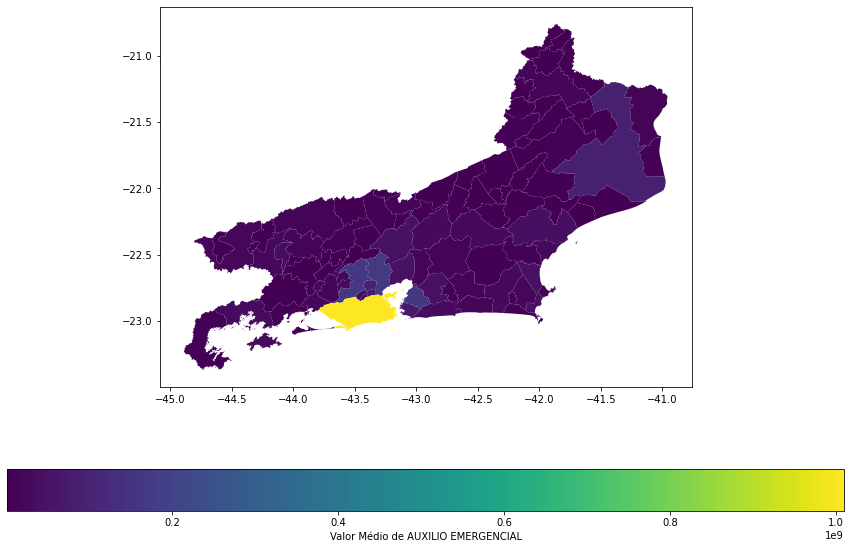

In [ ]:
mapa_rj.plot(column='AUXILIO EMERGENCIAL', legend=True,
             legend_kwds={'label': "Valor Médio de AUXILIO EMERGENCIAL",
                           'orientation': "horizontal"}, figsize=(15,10))

# Comparação dos valores de diferentes repasses por município

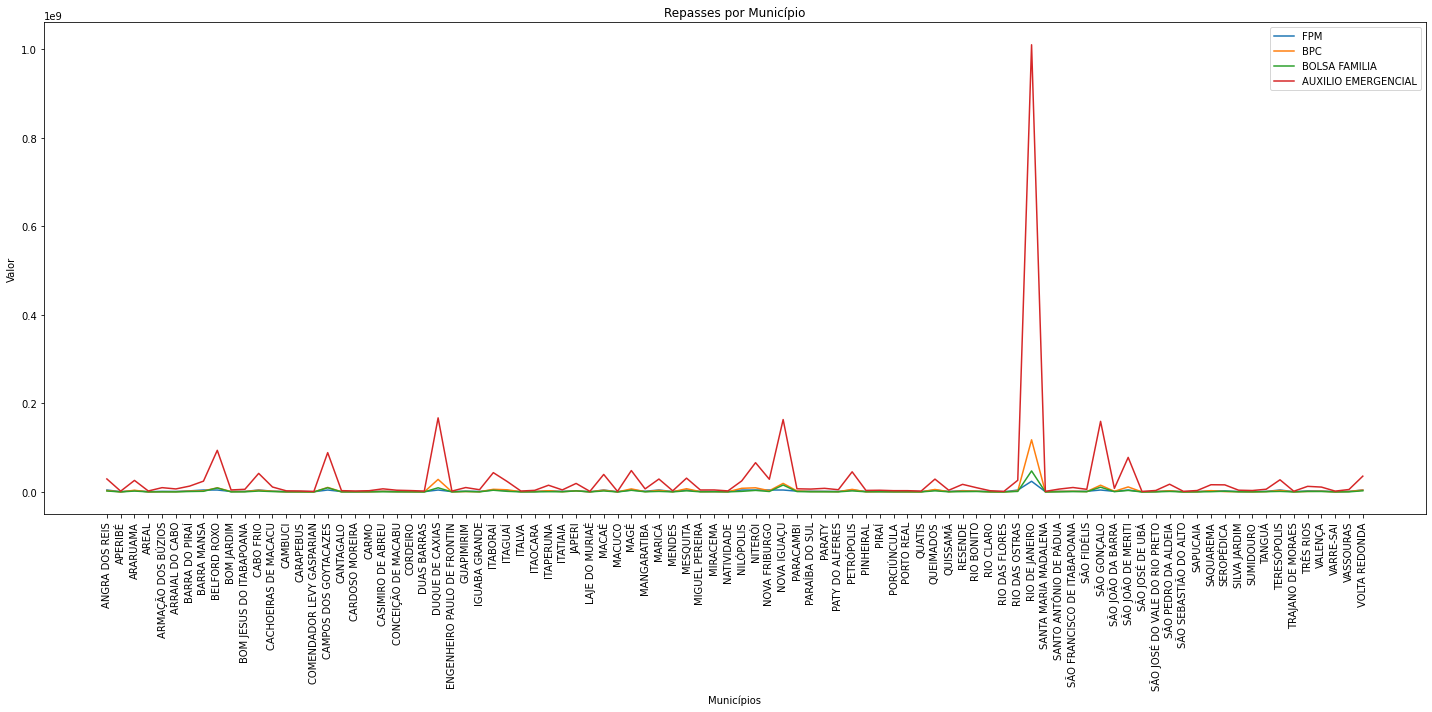

In [ ]:
fig = plt.figure(figsize=(20, 10))
plt.subplot(1, 1, 1)
plt.title('Repasses por Município')
for repasse in ['FPM','BPC','BOLSA FAMILIA','AUXILIO EMERGENCIAL']:
  dado = mapa_rj[['NM_MUNICIP', repasse]]
  plt.plot(dado['NM_MUNICIP'], dado[repasse],
          label=repasse)

plt.legend(loc='upper right')
plt.xlabel('Municípios')
plt.xticks(rotation='90')
plt.ylabel('Valor')
fig.tight_layout()
plt.show()

O Auxílio Emergencial é um valor muito discrepante e dificulta a visualização da relação dos demais beneficios com o FPM.
Vamos avaliar plotando sem o Auxílio Emergencial.

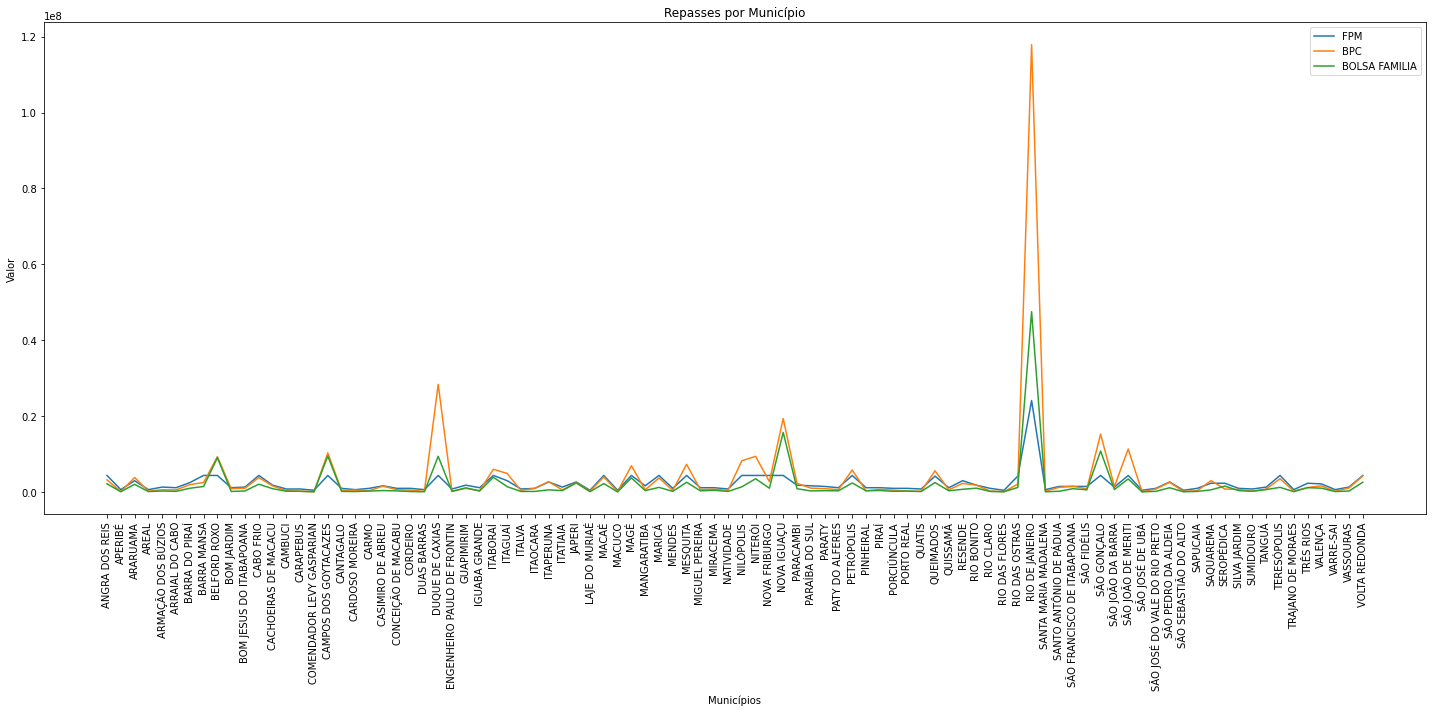

In [ ]:
fig = plt.figure(figsize=(20, 10))
plt.subplot(1, 1, 1)
plt.title('Repasses por Município')
for repasse in ['FPM','BPC','BOLSA FAMILIA']:
  dado = mapa_rj[['NM_MUNICIP', repasse]]
  plt.plot(dado['NM_MUNICIP'], dado[repasse],
          label=repasse)

plt.legend(loc='upper right')
plt.xlabel('Municípios')
plt.xticks(rotation='90')
plt.ylabel('Valor')
fig.tight_layout()
plt.show()

A lista dos municípios que valores de BPC ou BOLSA FAMILIA são maiores que FPM é:

In [ ]:
mapa_rj.iloc[[i 
              for i, row in mapa_rj.iterrows() 
              if row['BPC'] > row['FPM'] or 
              row['BOLSA FAMILIA'] > row['FPM']
              ]].NM_MUNICIP

2                        ARARUAMA
8                    BELFORD ROXO
16          CAMPOS DOS GOYTACAZES
24                DUQUE DE CAXIAS
28                       ITABORAÍ
29                        ITAGUAÍ
31                       ITAOCARA
32                      ITAPERUNA
38                           MAGÉ
42                       MESQUITA
46                      NILÓPOLIS
47                        NITERÓI
49                    NOVA IGUAÇU
50                      PARACAMBI
54                     PETRÓPOLIS
60                      QUEIMADOS
63                     RIO BONITO
67                 RIO DE JANEIRO
70    SÃO FRANCISCO DE ITABAPOANA
72                    SÃO GONÇALO
73              SÃO JOÃO DA BARRA
74             SÃO JOÃO DE MERITI
80                      SAQUAREMA
Name: NM_MUNICIP, dtype: object

## Boxplot para avaliar a distribuição dos valores médio de repasses entre os municípios

(array([1, 2, 3]), <a list of 3 Text major ticklabel objects>)

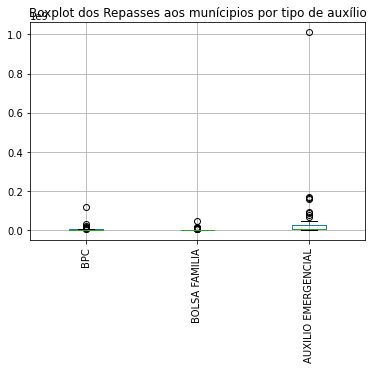

In [ ]:
ax = mapa_rj.boxplot(column=['BPC','BOLSA FAMILIA','AUXILIO EMERGENCIAL'])
ax.set_title('Boxplot dos Repasses aos munícipios por tipo de auxílio')
plt.xticks(rotation=90)

Percebemos que um município recebeu repasses de Auxílio Emergencial muito acima dos demais municípios, além disso, este repasse é maior do que todos os outros. Vamos analisar os boxplots dos repasses, desconsiderando o Auxílio Emergencial.

(array([1, 2]), <a list of 2 Text major ticklabel objects>)

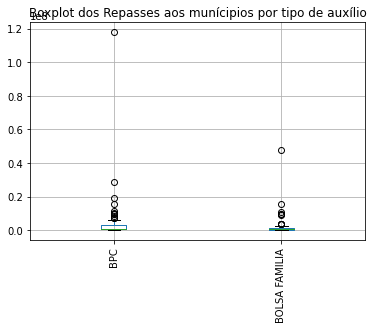

In [ ]:
ax = mapa_rj.boxplot(column=['BPC','BOLSA FAMILIA'])
ax.set_title('Boxplot dos Repasses aos munícipios por tipo de auxílio')
plt.xticks(rotation=90)

# BOXPLOTS INDIVIDUAIS

(array([1]), <a list of 1 Text major ticklabel objects>)

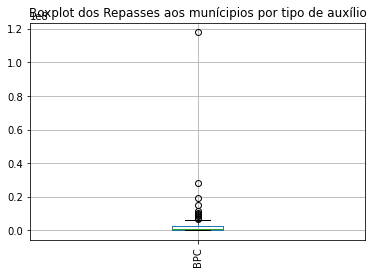

In [ ]:
ax = mapa_rj.boxplot(column=['BPC'])
ax.set_title('Boxplot dos Repasses aos munícipios por tipo de auxílio')
plt.xticks(rotation=90)

(array([1]), <a list of 1 Text major ticklabel objects>)

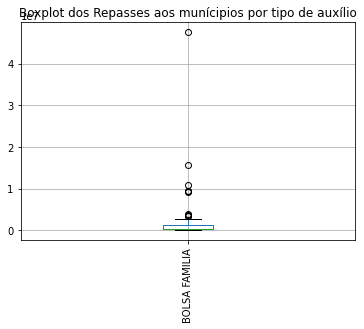

In [ ]:
ax = mapa_rj.boxplot(column=['BOLSA FAMILIA'])
ax.set_title('Boxplot dos Repasses aos munícipios por tipo de auxílio')
plt.xticks(rotation=90)

(array([1]), <a list of 1 Text major ticklabel objects>)

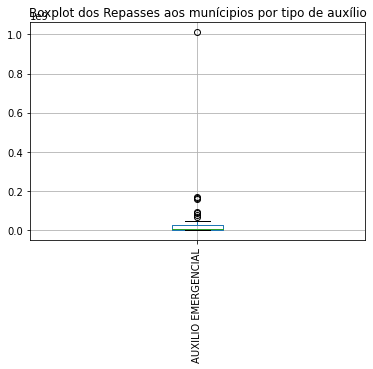

In [ ]:
ax = mapa_rj.boxplot(column=['AUXILIO EMERGENCIAL'])
ax.set_title('Boxplot dos Repasses aos munícipios por tipo de auxílio')
plt.xticks(rotation=90)

Ainda sim vemos municípios com médias de repasses muito maiores que outros. Vamos plotar boxplots de cada tipo de repasse exluindo os 10 maioires recebedores.

In [ ]:
from scipy.stats import variation 

def boxplot_exceto_top_n(df, column, top=10):
  ax = df[[column]].sort_values(column, ascending=False)[top:].boxplot(column=[column])
  ax.set_title('Boxplot do repasse médio dos munícipios')
  plt.xticks(rotation=90)
  plt.show()
  print(df[[column]].describe())
  print('Coeficiente de Variação: ' + str(variation(df[[column]], axis = 0)[0]))


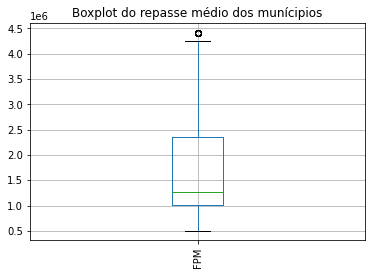

              FPM
count       92.00
mean   2315555.05
std    2713498.20
min     506171.76
25%    1012343.50
50%    1349791.33
75%    3338953.16
max   24149461.22
Coeficiente de Variação: 1.1654702951238058


In [ ]:
boxplot_exceto_top_n(mapa_rj, 'FPM')

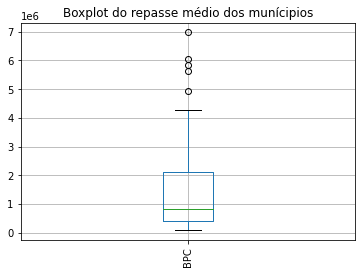

               BPC
count        92.00
mean    3891339.76
std    12765946.49
min       82092.13
25%      444367.39
50%      929720.53
75%     2860229.11
max   117852859.67
Coeficiente de Variação: 3.2627263487796383


In [ ]:
boxplot_exceto_top_n(mapa_rj, 'BPC')

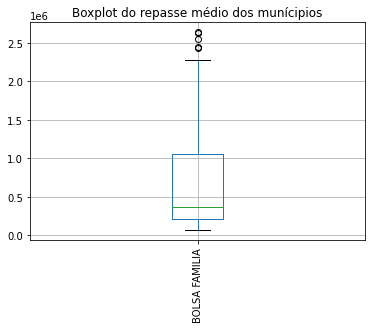

       BOLSA FAMILIA
count          92.00
mean      1905535.30
std       5437716.81
min         69426.78
25%        216876.00
50%        425620.94
75%       1310976.00
max      47533532.78
Coeficiente de Variação: 2.838091346781201


In [ ]:
boxplot_exceto_top_n(mapa_rj, 'BOLSA FAMILIA')

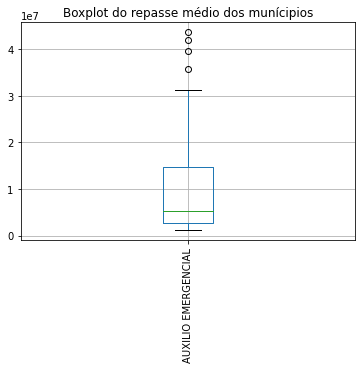

       AUXILIO EMERGENCIAL
count                92.00
mean           30120723.67
std           108314324.22
min             1197989.00
25%             2952253.08
50%             6537236.78
75%            24606667.42
max          1010316090.67
Coeficiente de Variação: 3.5764097908494126


In [ ]:
boxplot_exceto_top_n(mapa_rj, 'AUXILIO EMERGENCIAL')

## Quais municípios recebem mais e menos repasses?

A partir dos mapas, podemos inferir que um dos municípios que recebe muito acima da média de repasses é o Rio de Janeiro, mas os demais municípios que recebem repasses acima da média não ficam tão claros. Vamos descobrir quem são.

In [ ]:
colunas_para_avaliar = ['NM_MUNICIP','BPC', 'Área Territorial - km² [2020]',	'População estimada - pessoas [2020]',	'Densidade demográfica - hab/km² [2010]']
mapa_rj[colunas_para_avaliar].sort_values('BPC',ascending=False).head(5)

,NM_MUNICIP,BPC,Área Territorial - km² [2020],População estimada - pessoas [2020],Densidade demográfica - hab/km² [2010]
67,RIO DE JANEIRO,117852859.67,1.200.329,6747815,5265.82
24,DUQUE DE CAXIAS,28416651.60,467.319,924624,1828.51
49,NOVA IGUAÇU,19415190.33,520.581,823302,1527.60
72,SÃO GONÇALO,15310780.65,248.160,1091737,4035.90
74,SÃO JOÃO DE MERITI,11389637.04,35.216,472906,13024.56


In [ ]:
colunas_para_avaliar = ['NM_MUNICIP','FPM', 'Área Territorial - km² [2020]',	'População estimada - pessoas [2020]',	'Densidade demográfica - hab/km² [2010]']
mapa_rj[colunas_para_avaliar].sort_values('FPM',ascending=False).head(5)

,NM_MUNICIP,FPM,Área Territorial - km² [2020],População estimada - pessoas [2020],Densidade demográfica - hab/km² [2010]
67,RIO DE JANEIRO,24149461.22,1.200.329,6747815,5265.82
42,MESQUITA,4413445.33,41.169,176569,4310.48
46,NILÓPOLIS,4413445.12,19.393,162693,8117.62
24,DUQUE DE CAXIAS,4413445.12,467.319,924624,1828.51
85,TERESÓPOLIS,4413445.12,773.338,184240,212.49


In [ ]:
colunas_para_avaliar = ['NM_MUNICIP','BOLSA FAMILIA', 'Área Territorial - km² [2020]',	'População estimada - pessoas [2020]',	'Densidade demográfica - hab/km² [2010]']
mapa_rj[colunas_para_avaliar].sort_values('BOLSA FAMILIA',ascending=False).head(5)

,NM_MUNICIP,BOLSA FAMILIA,Área Territorial - km² [2020],População estimada - pessoas [2020],Densidade demográfica - hab/km² [2010]
67,RIO DE JANEIRO,47533532.78,1.200.329,6747815,5265.82
49,NOVA IGUAÇU,15739079.11,520.581,823302,1527.60
72,SÃO GONÇALO,10856986.67,248.160,1091737,4035.90
16,CAMPOS DOS GOYTACAZES,9514689.78,4.032.487,511168,115.16
24,DUQUE DE CAXIAS,9458914.56,467.319,924624,1828.51


In [ ]:
colunas_para_avaliar = ['NM_MUNICIP','AUXILIO EMERGENCIAL', 'Área Territorial - km² [2020]',	'População estimada - pessoas [2020]',	'Densidade demográfica - hab/km² [2010]']
mapa_rj[colunas_para_avaliar].sort_values('AUXILIO EMERGENCIAL',ascending=False).head(5)

,NM_MUNICIP,AUXILIO EMERGENCIAL,Área Territorial - km² [2020],População estimada - pessoas [2020],Densidade demográfica - hab/km² [2010]
67,RIO DE JANEIRO,1010316090.67,1.200.329,6747815,5265.82
24,DUQUE DE CAXIAS,167405029.11,467.319,924624,1828.51
49,NOVA IGUAÇU,163562353.22,520.581,823302,1527.60
72,SÃO GONÇALO,159548020.56,248.160,1091737,4035.90
8,BELFORD ROXO,94120832.22,78.985,513118,6031.38


Além do Rio de Janeiro, quais outros municípios estão entre os que mais recebem repasses de todos os tipos?

In [ ]:
maiores = [mapa_rj[['NM_MUNICIP','BPC']].sort_values('BPC',ascending=False).head(5).NM_MUNICIP.tolist(),
mapa_rj[['NM_MUNICIP','FPM']].sort_values('FPM',ascending=False).head(5).NM_MUNICIP.tolist(),
mapa_rj[['NM_MUNICIP','BOLSA FAMILIA']].sort_values('BOLSA FAMILIA',ascending=False).head(5).NM_MUNICIP.tolist(),
mapa_rj[['NM_MUNICIP','AUXILIO EMERGENCIAL']].sort_values('AUXILIO EMERGENCIAL',ascending=False).head(5).NM_MUNICIP.tolist(),]
set.intersection(*map(set,maiores))

{'DUQUE DE CAXIAS', 'RIO DE JANEIRO'}

E quais munícipios são os que menos recebem repasses?

In [ ]:
colunas_para_avaliar = ['NM_MUNICIP','BPC', 'Área Territorial - km² [2020]',	'População estimada - pessoas [2020]',	'Densidade demográfica - hab/km² [2010]']
mapa_rj[colunas_para_avaliar].sort_values('BPC',ascending=False).tail(5)

,NM_MUNICIP,BPC,Área Territorial - km² [2020],População estimada - pessoas [2020],Densidade demográfica - hab/km² [2010]
1,APERIBÉ,172080.00,94.542,11901,107.92
37,MACUCO,155823.78,78.364,5623,67.80
65,RIO DAS FLORES,126099.10,478.783,9344,17.90
75,SÃO JOSÉ DE UBÁ,104384.76,249.688,7206,27.98
15,COMENDADOR LEVY GASPARIAN,82092.13,108.639,8576,76.53


In [ ]:
colunas_para_avaliar = ['NM_MUNICIP','FPM', 'Área Territorial - km² [2020]',	'População estimada - pessoas [2020]',	'Densidade demográfica - hab/km² [2010]']
mapa_rj[colunas_para_avaliar].sort_values('FPM',ascending=False).tail(5)

,NM_MUNICIP,FPM,Área Territorial - km² [2020],População estimada - pessoas [2020],Densidade demográfica - hab/km² [2010]
37,MACUCO,506171.76,78.364,5623,67.80
65,RIO DAS FLORES,506171.76,478.783,9344,17.90
35,LAJE DO MURIAÉ,506171.76,253.530,7326,29.95
75,SÃO JOSÉ DE UBÁ,506171.76,249.688,7206,27.98
15,COMENDADOR LEVY GASPARIAN,506171.76,108.639,8576,76.53


In [ ]:
colunas_para_avaliar = ['NM_MUNICIP','BOLSA FAMILIA', 'Área Territorial - km² [2020]',	'População estimada - pessoas [2020]',	'Densidade demográfica - hab/km² [2010]']
mapa_rj[colunas_para_avaliar].sort_values('BOLSA FAMILIA',ascending=False).tail(5)

,NM_MUNICIP,BOLSA FAMILIA,Área Territorial - km² [2020],População estimada - pessoas [2020],Densidade demográfica - hab/km² [2010]
78,SÃO SEBASTIÃO DO ALTO,116806.33,397.214,9387,22.35
23,DUAS BARRAS,112691.44,379.619,11528,29.14
68,SANTA MARIA MADALENA,106868.22,810.963,10392,12.67
75,SÃO JOSÉ DE UBÁ,96283.00,249.688,7206,27.98
37,MACUCO,69426.78,78.364,5623,67.80


In [ ]:
colunas_para_avaliar = ['NM_MUNICIP','AUXILIO EMERGENCIAL', 'Área Territorial - km² [2020]',	'População estimada - pessoas [2020]',	'Densidade demográfica - hab/km² [2010]']
mapa_rj[colunas_para_avaliar].sort_values('AUXILIO EMERGENCIAL',ascending=False).head(5).tail(5)

,NM_MUNICIP,AUXILIO EMERGENCIAL,Área Territorial - km² [2020],População estimada - pessoas [2020],Densidade demográfica - hab/km² [2010]
67,RIO DE JANEIRO,1010316090.67,1.200.329,6747815,5265.82
24,DUQUE DE CAXIAS,167405029.11,467.319,924624,1828.51
49,NOVA IGUAÇU,163562353.22,520.581,823302,1527.60
72,SÃO GONÇALO,159548020.56,248.160,1091737,4035.90
8,BELFORD ROXO,94120832.22,78.985,513118,6031.38


Quais municípios estão entre os que menos recebem repasses de todos os tipos?

In [ ]:
menores = [mapa_rj[['NM_MUNICIP','BPC']].sort_values('BPC',ascending=False).tail(5).NM_MUNICIP.tolist(),
mapa_rj[['NM_MUNICIP','FPM']].sort_values('FPM',ascending=False).tail(5).NM_MUNICIP.tolist(),
mapa_rj[['NM_MUNICIP','BOLSA FAMILIA']].sort_values('BOLSA FAMILIA',ascending=False).tail(5).NM_MUNICIP.tolist(),
mapa_rj[['NM_MUNICIP','AUXILIO EMERGENCIAL']].sort_values('AUXILIO EMERGENCIAL',ascending=False).tail(5).NM_MUNICIP.tolist(),]
set.intersection(*map(set,menores))

{'MACUCO', 'SÃO JOSÉ DE UBÁ'}

## Qual a correlação entre os valores médios de cada tipo de repasse? 

Os valores de repasses estão correlacionados? Para isso vamos analisar a correlação de Pearson.

In [ ]:
v = np.array([mapa_rj['BPC'].tolist(), mapa_rj['FPM'].tolist(), 
     mapa_rj['BOLSA FAMILIA'].tolist(),mapa_rj['AUXILIO EMERGENCIAL'].tolist()])
np.corrcoef(v)

array([[1.        , 0.92324116, 0.97137647, 0.99468916],
       [0.92324116, 1.        , 0.90843526, 0.92150122],
       [0.97137647, 0.90843526, 1.        , 0.97730426],
       [0.99468916, 0.92150122, 0.97730426, 1.        ]])

<table>
<thead>
<th></th>
<th>BPC</th>
<th>FPM</th>
<th>BOLSA FAMILIA</th>
<th>AUXILIO EMERGENCIAL</th>
<thead>
<tbody>
<tr>
<td>BPC</td>
<td></td>
<td>0.92324116</td>
<td>0.97137647</td>
<td>0.99468916</td>
</tr>
<tr>
<td>FPM</td>
<td>0.92324116</td>
<td></td>
<td>0.90843526</td>
<td>0.92150122</td>
</tr>
<tr>
<td>BOLSA FAMILIA</td>
<td>0.97137647</td>
<td>0.97137647</td>
<td></td>
<td>0.97730426</td>
</tr>
<tr>
<td>AUXILIO EMERGENCIAL</td>
<td>0.99468916</td>
<td>0.92150122</td>
<td>0.97730426</td>
<td></td>
</tr>
<tbody>
<table>

A correlação de Pearson entre os valores médios de repasses por município mostra uma correlação positiva forte, ou seja, quanto maior o valor de um tipo de repasse, maior o valor de outro tipo de repasse.

# Treinamento de Modelos de Machine Learning

<img src="https://miro.medium.com/max/601/1*PdwlCactbJf8F8C7sP-3gw.png"/>

Antes de gerarmos nossos modelos precisamos dividir nosso dados entre os dados que vamos treinar e o dado que vamos fazer a predição (ou testar), ou seja <b>TRAINING SET</b> e <b>TEST SET</b>.
Além disso, precisamos de ter um processo que nos auxilie a escolher qual modelo se ajusta melhor aos nossos dados como um todo. Apesar de podermos treinar os modelos escolhidos com todo o dado de treinamento e avaliá-lo apenas no conjunto de teste, esse processo pode esconder algumas informações. 

Imagine que um modelo, que seja um pouco mais sofisticado, consiga encontrar um "atalho" nos dados que o faça ter um desempenho melhor que os outros modelos. Além disso, imagine que, num ambiente de produção, os dados usados para predição sejam exatamente os dados que esse modelo "ignorou" ao tomar os atalhos que o dava um melhor desempenho no conjunto de teste (?).
Para mitigar esse risco, podemos fazer uso do processo K-Cross Validation, onde avaliamos um mesmo modelo, em diferentes recortes dos dados de treinamento antes de avaliá-lo nos dados de teste.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.api import OLS

class OLSWrapper:

  def __init__(self):
    self.model = None
  
  def fit(self, X, y):
    self.model = OLS(y,X).fit()
  
  def predict(self, X):
    return self.model.predict(X)
  
  def __str__(self):
    return 'OLS'

from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit

Vamos usar como modelos de regressão:
- OLS (statsmodel)
- Linear Regression (sklearn)
- KNR (k=5)
- SVR (kernels= [RBF, polinomial e linear])

**OBS. 1:** _Os modelos OLS do statsmodel e Linear Regression do sklearn seguem basicamente o mesmo procedimento, no entanto a fórmula da regressão utilizada tem uma pequena diferença de tratamento. Por exemplo, enquanto no OLS uma fórmula seria utilizada do seguinte modo:_

y = B0 + B1x1

_o Linear Regression acrescentaria um termo:_ 

y = B0**x0**+ B1x1

_o que em casos de borda podem alterar os resultados obtidos, como será visto nos resultados do K-Fold Cross Validation_(https://stats.stackexchange.com/a/482178)

**OBS. 2:** As interfaces utilizadas nos modelos do statsmodels e do sklearn são diferentes, por isso foi criado uma classe que serve como um proxy convertendo as interfaces usadas do sklearn para a forma esperada pelo statsmodels ao usar o OLS.

In [ ]:
treino = dados[dados['Mês/Ano'] != '12/2020']
teste = dados[dados['Mês/Ano'] == '12/2020']
print('Total de dados de treinamento: '+str(len(treino)))
print('Total de dados de teste: '+str(len(teste)))

Total de dados de treinamento: 736
Total de dados de teste: 92


Os dados de treinamento são de todos os meses, exceto dezembro, que é o mês que vamos tentar prever.

In [ ]:
X_train = treino[['BPC','FPM','BOLSA FAMILIA']].values
y_train = treino[['AUXILIO EMERGENCIAL']].values

modelos = [LinearRegression(), OLSWrapper(), SVR(), SVR(kernel='poly'), LinearSVR(max_iter=1000), KNeighborsRegressor(n_neighbors=5)]


def treino_kfold(X_train, y_train, modelos, n_split=10, shuffle=False):
  if shuffle:
    random_state = 42
  else:
    random_state = None
  kf = KFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
  resp = {}

  for train, test in kf.split(X_train):
    X_, X_test, y_, y_test = X_train[train], X_train[test], y_train[train], y_train[test]
    for modelo in modelos:
      if str(modelo) not in resp.keys():
        resp[str(modelo)] = {'preditos': [], 'reais': []}
      
      modelo.fit(X_, y_.ravel())
      y_predict = modelo.predict(X_test)

      resp[str(modelo)]['preditos'].append(y_predict.ravel())
      resp[str(modelo)]['reais'].append(y_test.ravel())
  
  return resp

X = [A,B,C,D]

[0,1]
[2,3]

Os dados de resultados que estamos guardando vão ser parecidos com a seguinte estrutura:



```
{ 'LinearRegression': {
                        'preditos':[
                                      [1,2,3,4],
                                      [2,4,5,6]
                                    ], 
                        'reais': [
                                    [1,3,3,4],
                                    [3,4,1,6]
                                  ]
                        }
    }
```



In [ ]:
def nome_display_modelo(nome):
  tmp = str(nome).split('(')[0].strip()
  kernel = [ k for k in nome.split(',') if 'kernel' in k]
  if len(kernel) > 0:
    return tmp + ' ' + kernel[0].strip()
  return tmp

def plota_metrica(resultados, modelos, metrica, titulo, eixo_x, eixo_y, loc='upper left'):
  resp = []
  fig = plt.figure(figsize=(10, 5))
  plt.subplot(1, 1, 1)
  
  boxplots_data = []
  boxplots_ticks = []

  for nome_modelo in modelos:  
    modelo = resultados[str(nome_modelo)]
    for i, d in enumerate(zip(modelo['reais'], modelo['preditos'])):
      real , predito = d
      resp.append([i, metrica(real, predito)])

    nome_display = nome_display_modelo(str(nome_modelo))
    plt.plot([ x[0] for x in resp], [ x[1] for x in resp],
            label=nome_display)
    print(nome_display, resp)

    boxplots_data.append([ x[1] for x in resp])
    boxplots_ticks.append(nome_display)

    resp = []

  plt.title(titulo)
  plt.legend(loc=loc)
  plt.xlabel(eixo_x)
  plt.ylabel(eixo_y)
  fig.tight_layout()
  plt.show()

  fig2, ax2 = plt.subplots()
  ax2.set_title('Boxplots '+eixo_y)
  ax2.boxplot(boxplots_data)
  plt.xticks(list(range(1, len(boxplots_ticks)+1)), boxplots_ticks, rotation=90)
  plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
  return mean_squared_error(y_true, y_pred, squared=False)
# R^2 (coefficient of determination) regression score function.
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
# A constant model that always predicts the expected value of y, disregarding the input features, 
# would get a R^2 score of 0.0.
# https://www.geeksforgeeks.org/python-coefficient-of-determination-r2-score/
from sklearn.metrics import r2_score

from sklearn.metrics import mean_absolute_percentage_error

Vamos fazer uma primeira avaliação dos modelos usando o KFold Cross Validation com K = 10, escolha arbitrária.

In [ ]:
resp_10_fold = treino_kfold(X_train, y_train, modelos, n_split=10)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

LinearRegression [[0, 73702815587955.02], [1, 53566928836020.53], [2, 37111744625899.086], [3, 40499345733849.805], [4, 20270588345262.176], [5, 9147418947330.496], [6, 22271547611831.074], [7, 50918768310137.06], [8, 374884446806049.8], [9, 2.859742540070816e+16]]
OLS [[0, 250291057811.17578], [1, 737545572427.4434], [2, 2503079906790.4673], [3, 4982544885477.221], [4, 11035550488723.748], [5, 13298074923999.158], [6, 53833613335511.234], [7, 50936737847751.59], [8, 318081990890086.8], [9, 2.7918483004921732e+16]]
SVR [[0, 40981655484593.375], [1, 32884319932374.21], [2, 25543798662341.54], [3, 11025383847239.145], [4, 18212586967712.234], [5, 11766788818765.195], [6, 109438589340060.86], [7, 476569136429566.0], [8, 1130002875734389.5], [9, 1.3045937207296603e+17]]
SVR SVR(kernel='poly') [[0, 40981709508836.21], [1, 32884351240270.37], [2, 25543810153310.977], [3, 11025396968245.287], [4, 18212597246503.26], [5, 11766806515946.58], [6, 109438354575352.8], [7, 476565760624419.75], [8, 

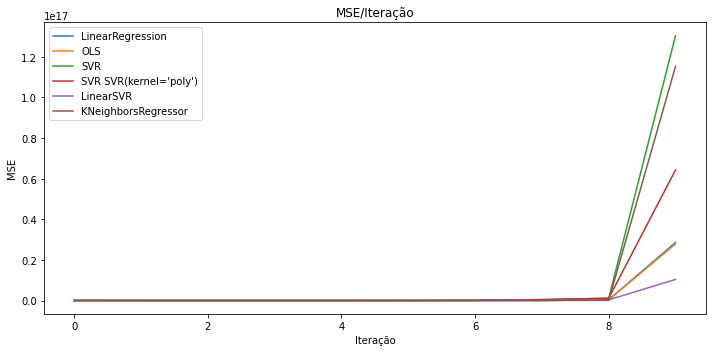

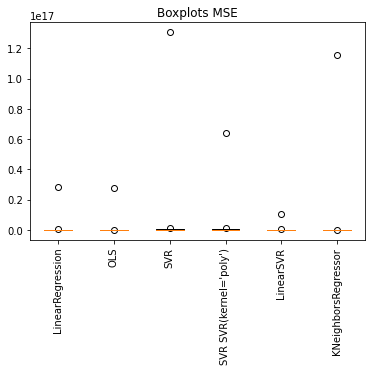

In [ ]:
plota_metrica(resp_10_fold, modelos, mean_squared_error, 'MSE/Iteração', 'Iteração', 'MSE', loc='upper left')

LinearRegression [[0, 8585034.396434007], [1, 7318943.150211001], [2, 6091940.957190827], [3, 6363909.626467821], [4, 4502287.012759424], [5, 3024470.0275139934], [6, 4719274.055597013], [7, 7135738.80618798], [8, 19361932.930522453], [9, 169107733.11918104]]
OLS [[0, 500290.9731458042], [1, 858804.7347490833], [2, 1582112.4823445606], [3, 2232161.4828406167], [4, 3321979.9049247345], [5, 3646652.5642017443], [6, 7337139.315531036], [7, 7136997.817552672], [8, 17834853.262364868], [9, 167088249.1527209]]
SVR [[0, 6401691.611175391], [1, 5734485.149721308], [2, 5054087.322389823], [3, 3320449.3441760475], [4, 4267620.761936589], [5, 3430275.326962137], [6, 10461290.04186677], [7, 21830463.495527666], [8, 33615515.40188532], [9, 361191600.2248198]]
SVR SVR(kernel='poly') [[0, 6401695.83070269], [1, 5734487.87951203], [2, 5054088.45918935], [3, 3320451.3199631893], [4, 4267621.966212947], [5, 3430277.9065181557], [6, 10461278.82122223], [7, 21830386.17671295], [8, 33615040.3624157], [9, 2

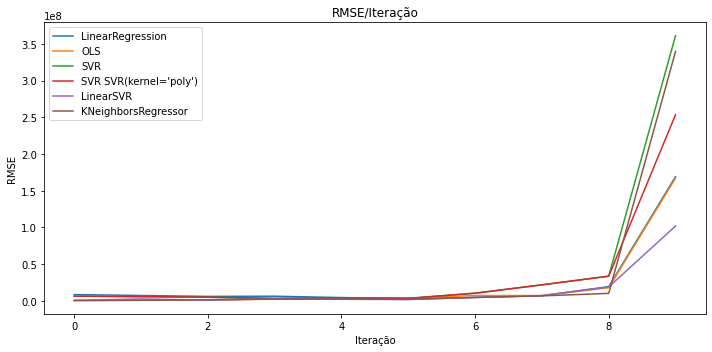

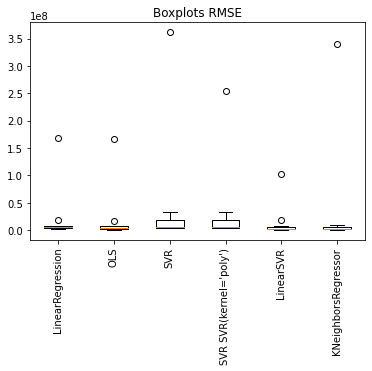

In [ ]:
plota_metrica(resp_10_fold, modelos, rmse, 'RMSE/Iteração', 'Iteração', 'RMSE', loc='upper left')

LinearRegression [[0, 5.72630280841444], [1, 3.580870407542419], [2, 2.0986065596372234], [3, 1.3215057183304295], [4, 0.7153580763218873], [5, 0.3799241872358207], [6, 0.3691506194912004], [7, 0.27579602622258076], [8, 0.5252940092023596], [9, 0.30708497950846364]]
OLS [[0, 0.27352033393044317], [1, 0.4297588787347003], [2, 0.5695555298987176], [3, 0.4498422164516979], [4, 0.618043498112336], [5, 0.5568741580200162], [6, 0.6641192768556424], [7, 0.29339425342118447], [8, 0.4882632272369287], [9, 0.2984658949334771]]
SVR [[0, 4.3546583996745], [1, 2.9656711268996876], [2, 1.9029195909657666], [3, 0.8415578238882787], [4, 0.6342247820709973], [5, 0.3167901935348458], [6, 0.5081556998835992], [7, 0.7549551450178246], [8, 0.838883820077286], [9, 0.9310938759012518]]
SVR SVR(kernel='poly') [[0, 4.354661306432743], [1, 2.965672583981489], [2, 1.9029200224205787], [3, 0.8415583490822879], [4, 0.634224726266647], [5, 0.31679020841655947], [6, 0.5081550615239488], [7, 0.7549524139009988], [8, 

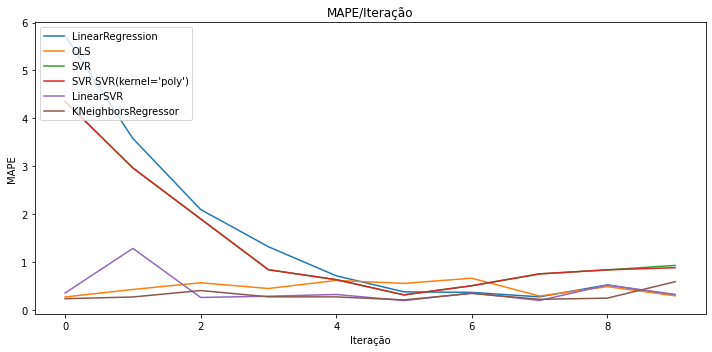

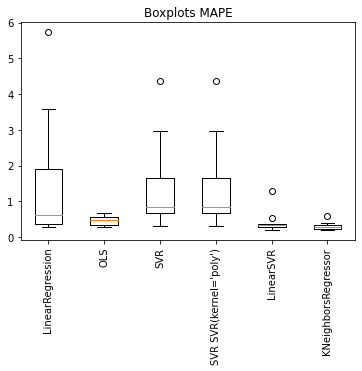

In [ ]:
plota_metrica(resp_10_fold, modelos, mean_absolute_percentage_error, 'MAPE/Iteração', 'Iteração', 'MAPE', loc='upper left')

LinearRegression [[0, -327.4215144878936], [1, -71.75563893318326], [2, -31.34266782260633], [3, -6.168594532817659], [4, -0.16158377710416105], [5, 0.06773751434415365], [6, 0.49775718527396173], [7, 0.3903335622998614], [8, -2.004743461974443], [9, 0.6806756954439113]]
OLS [[0, -0.1153029584199099], [1, -0.0017486634069545648], [2, -1.181419461004475], [3, 0.11806367786091865], [4, 0.3676199131086637], [5, -0.355278079474326], [6, -0.21399491224118994], [7, 0.39011840737078207], [8, -1.5494650168649753], [9, 0.6882568956859014]]
SVR [[0, -181.61524004343255], [1, -43.66411943994582], [2, -21.26127074842776], [3, -0.9515502025375948], [4, -0.04365227098787372], [5, -0.19921650637536126], [6, -1.4679355969228127], [7, -4.706112252267533], [8, -8.057107548214326], [9, -0.4567342226196456]]
SVR SVR(kernel='poly') [[0, -181.61548077675474], [1, -43.66416196293601], [2, -21.261280762740242], [3, -0.9515525250238273], [4, -0.04365286000269197], [5, -0.1992183099899545], [6, -1.4679303027739

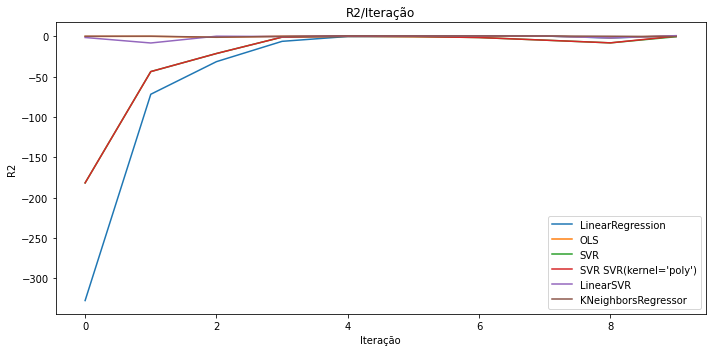

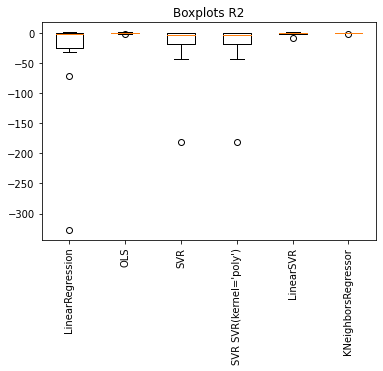

In [ ]:
plota_metrica(resp_10_fold, modelos, r2_score, 'R2/Iteração', 'Iteração', 'R2', loc='lower right')

O que podemos observar avaliando o MSE é que todos os modelos tem um comportamento similar nos primeiros folds, mas nos 2 folds finais o melhor foi SVR com kernel linear seguido dos modelos são o OLS e Linear Regression. O RMSE seguiu a mesma tendência.

Já usando o R2 score, o SVR com kernel linear e o KNR (K=5) têm seus resultados muito próximos em todos os folds. Seguido do OLS.

Contudo, algo que devemos prestar atenção é realizando o split dos dados em 10 folds sequenciais, podemos ter folds desbalanceados, pois o número de folds é maior que o numero de meses dos dados, e algum fold pode conter dados com uma variância muito diferente da distribuição original dos dados. Essa diferença entre a variância dos dados de um fold e os dados originais poderia justificar os resultados ruins de alguns modelos nos folds finais.

Vamos realizar o processo de cross-validation com um k=8, assim teremos folds que batem com os meses dos dados de treinamento, e portanto os dados não estaram desbalanceados.

In [ ]:
resp_8_fold = treino_kfold(X_train, y_train, modelos, n_split=8)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

LinearRegression [[0, 78653690691965.33], [1, 51681951019327.99], [2, 39421937264139.875], [3, 24913392745668.023], [4, 9609084891175.457], [5, 30040545873286.49], [6, 163982886235288.66], [7, 1.885063186060232e+16]]
OLS [[0, 282290844466.25793], [1, 1107794079451.6824], [2, 4431052049656.41], [3, 9868553727665.88], [4, 18226933362695.92], [5, 52318135461909.7], [6, 131689026660947.39], [7, 1.8663105559362376e+16]]
SVR [[0, 43221948722965.21], [1, 30723083946804.64], [2, 20940517513323.76], [3, 17848612781654.387], [4, 12701234311691.855], [5, 205040198270037.2], [6, 870633249364096.1], [7, 1.0386432200102269e+17]]
SVR SVR(kernel='poly') [[0, 43222054616414.016], [1, 30723153795202.72], [2, 20940539909432.504], [3, 17848627712669.547], [4, 12701243610201.764], [5, 205039601781184.2], [6, 870620147142128.1], [7, 4.090070748750873e+16]]
LinearSVR [[0, 174186466577.92758], [1, 1429687045776.892], [2, 3684185205306.456], [3, 6611871245673.878], [4, 6593420598457.807], [5, 50348676089276.61

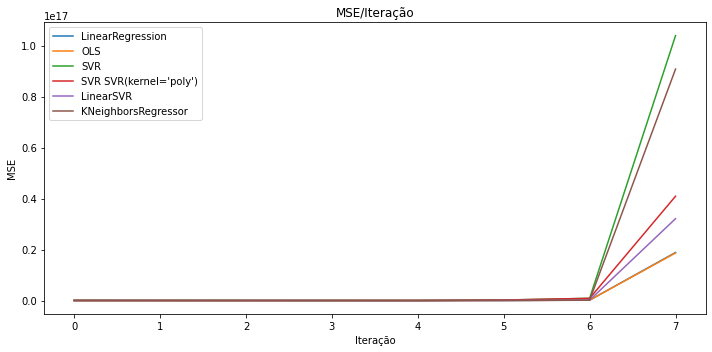

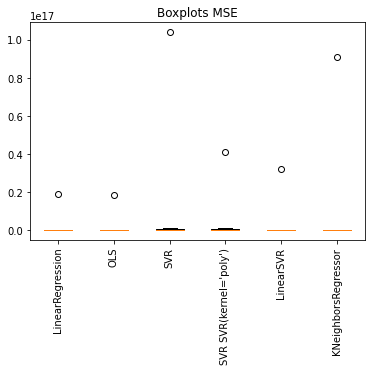

In [ ]:
plota_metrica(resp_8_fold, modelos, mean_squared_error, 'MSE/Iteração', 'Iteração', 'MSE', loc='upper left')

LinearRegression [[0, 8868691.599777576], [1, 7189015.9979880415], [2, 6278689.135810108], [3, 4991331.760729598], [4, 3099852.398288579], [5, 5480925.640189483], [6, 12805580.277179502], [7, 137297603.25876895]]
OLS [[0, 531310.4972294994], [1, 1052517.9710825286], [2, 2105006.4250867288], [3, 3141425.429270267], [4, 4269301.273357962], [5, 7233127.640371744], [6, 11475583.935510533], [7, 136612977.27288714]]
SVR [[0, 6574340.173961583], [1, 5542840.783100723], [2, 4576081.02128052], [3, 4224761.860940139], [4, 3563879.110139941], [5, 14319224.778947957], [6, 29506495.03692528], [7, 322279881.4710944]]
SVR SVR(kernel='poly') [[0, 6574348.227498602], [1, 5542847.083873298], [2, 4576083.468363804], [3, 4224763.628023412], [4, 3563880.4146887087], [5, 14319203.950680505], [6, 29506273.01341408], [7, 202239233.30429417]]
LinearSVR [[0, 417356.5221461473], [1, 1195695.2144158194], [2, 1919423.143891533], [3, 2571355.9157910985], [4, 2567765.682155949], [5, 7095680.1005454445], [6, 13164689

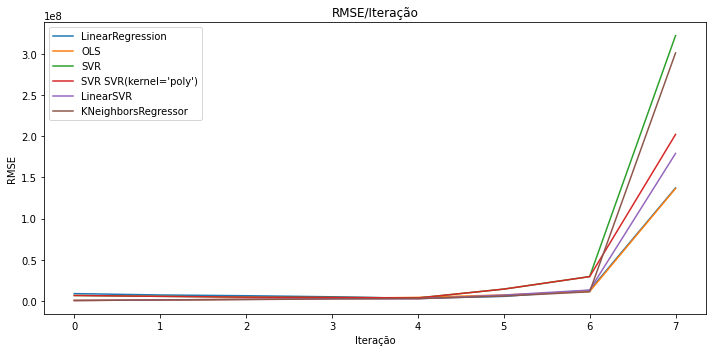

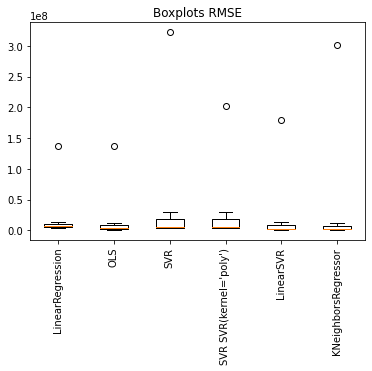

In [ ]:
plota_metrica(resp_8_fold, modelos, rmse, 'RMSE/Iteração', 'Iteração', 'RMSE', loc='upper left')

LinearRegression [[0, 5.631680369108014], [1, 2.9956439779903774], [2, 1.801044515203008], [3, 0.8381639951812027], [4, 0.3730462723115031], [5, 0.3452066430602125], [6, 0.38616316538642614], [7, 0.2972541983049297]]
OLS [[0, 0.2798975711316105], [1, 0.423988870971584], [2, 0.598739304479637], [3, 0.5800646898221966], [4, 0.6008740603837031], [5, 0.5044991519446225], [6, 0.3537591222048386], [7, 0.2902630669937064]]
SVR [[0, 4.253545874306161], [1, 2.5089340690723763], [2, 1.5468298178880688], [3, 0.7276758346623042], [4, 0.30937872421269885], [5, 0.6335948137026931], [6, 0.8175955818621072], [7, 0.9184721605094736]]
SVR SVR(kernel='poly') [[0, 4.253551085773068], [1, 2.5089369038373537], [2, 1.5468306621092018], [3, 0.7276761840833315], [4, 0.3093788279088711], [5, 0.6335937785920951], [6, 0.8175893719095689], [7, 0.8698939609095828]]
LinearSVR [[0, 0.21042485348459442], [1, 0.45050910860082916], [2, 0.31574991146044307], [3, 0.2543624726816689], [4, 0.2536615698906001], [5, 0.3774490

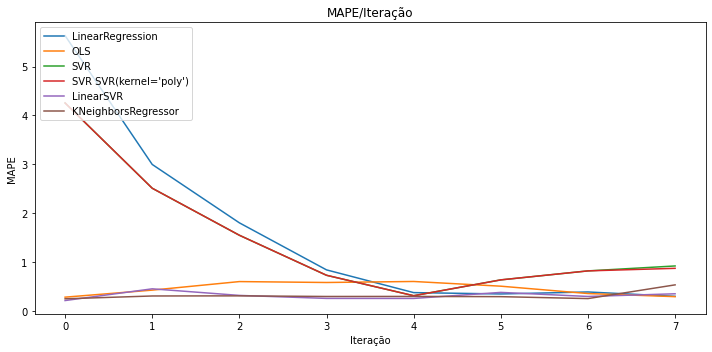

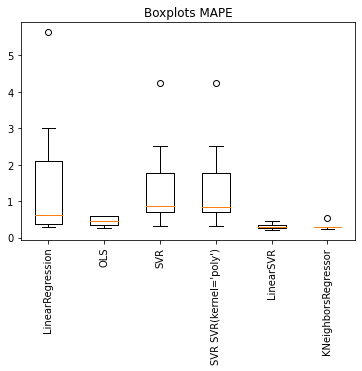

In [ ]:
plota_metrica(resp_8_fold, modelos, mean_absolute_percentage_error, 'MAPE/Iteração', 'Iteração', 'MAPE', loc='upper left')

LinearRegression [[0, -295.5878595363817], [1, -35.04499019554924], [2, -6.310248240142813], [3, -0.6681662895940439], [4, -0.07514440399924949], [5, 0.46575167968638276], [6, -0.38895119308686366], [7, 0.7507071598290496]]
OLS [[0, -0.06446419221263189], [1, 0.22738159173615125], [2, 0.17832322062347228], [3, 0.3392153038488759], [4, -1.0393810262792402], [5, 0.06956164810171339], [6, -0.11541902265779891], [7, 0.753187127852857]]
SVR [[0, -161.98161146613558], [1, -20.427466219792276], [2, -2.883126805102604], [3, -0.1951184032753006], [4, -0.42111982033164175], [5, -2.6464843876205597], [6, -6.374349349542815], [7, -0.3735683777359464]]
SVR SVR(kernel='poly') [[0, -161.98201076985603], [1, -20.4275149347648], [2, -2.8831309581484943], [3, -0.19511940303540598], [4, -0.42112086072633126], [5, -2.646473779518791], [6, -6.374238372432628], [7, 0.45910282424684123]]
LinearSVR [[0, 0.34317651431161145], [1, 0.0028809955634313544], [2, 0.3168192564206972], [3, 0.557278254480727], [4, 0.26

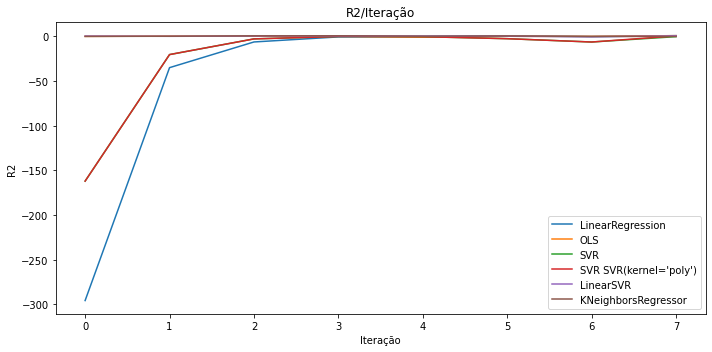

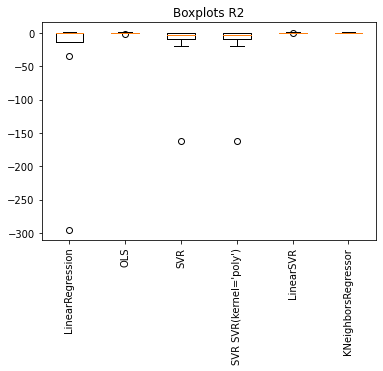

In [ ]:
plota_metrica(resp_8_fold, modelos, r2_score, 'R2/Iteração', 'Iteração', 'R2', loc='lower right')

Pelo gráfico, percebemos que diminuir a quantidade de folds (e consequentemente aumentar a quantidade de dados de teste a cada iteração) manteve o mesmo perfil das linhas dos modelos no MSE e RSME. O modelo SVR com kernel linear se destacou positivamente.

Em outra avaliação podemos também alterar como os folds do cross validation são gerados para usarem os dados de forma aleatória e não sequencial. Isso é desejável, já que na regressão não tem como premissa a dependência temporal. Vamos começar com 10 folds.

In [ ]:
resp_10_random_fold = treino_kfold(X_train, y_train, modelos, n_split=10, shuffle=True)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

LinearRegression [[0, 179106804596300.3], [1, 1235713578193080.5], [2, 1075247984600578.0], [3, 233010410946365.88], [4, 270196562046141.56], [5, 195046039184428.0], [6, 222691728185573.4], [7, 1379450977742664.0], [8, 676031699649273.6], [9, 1019585970465597.4]]
OLS [[0, 198162523397208.5], [1, 1300295764827767.0], [2, 1052207468267538.6], [3, 268110701418129.1], [4, 294219242064715.3], [5, 212600861256798.62], [6, 212900799323543.78], [7, 1596007628638486.2], [8, 503950743036656.1], [9, 1032668702072606.0]]
SVR [[0, 914526395206907.6], [1, 2.5291552116542692e+16], [2, 9043803083712710.0], [3, 1658585089504359.2], [4, 1.3864245669300468e+16], [5, 3007912022967733.0], [6, 1.390803101846132e+16], [7, 2.399406550630831e+16], [8, 1.8833141104639996e+16], [9, 2.0439640989678588e+16]]
SVR SVR(kernel='poly') [[0, 914234802393585.8], [1, 2.5015989600244772e+16], [2, 8952345534291833.0], [3, 1658062254029463.0], [4, 1.3739936527771938e+16], [5, 3007228846441470.5], [6, 1.3794087579807574e+16],

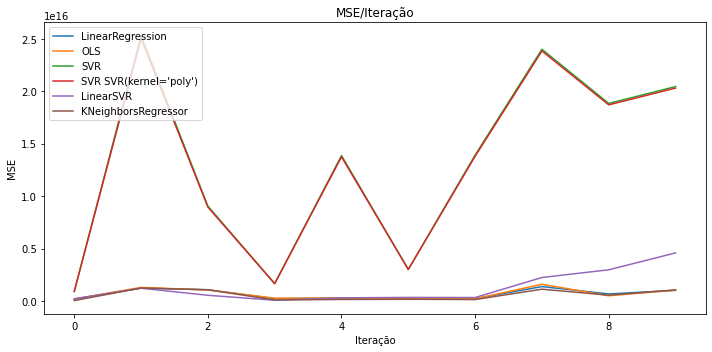

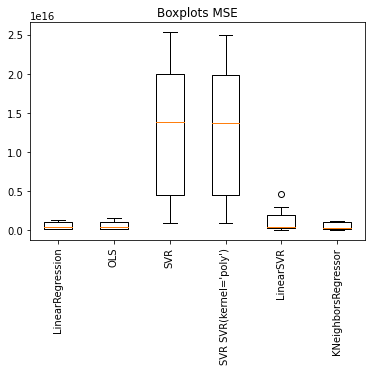

In [ ]:
plota_metrica(resp_10_random_fold, modelos, mean_squared_error, 'MSE/Iteração', 'Iteração', 'MSE', loc='upper left')

LinearRegression [[0, 13383079.040202232], [1, 35152717.934650235], [2, 32790974.1331449], [3, 15264678.54055125], [4, 16437656.829552732], [5, 13965888.41371819], [6, 14922859.24967375], [7, 37140960.91571493], [8, 26000609.601493455], [9, 31930956.30364987]]
OLS [[0, 14077021.112337954], [1, 36059614.041580744], [2, 32437747.58314052], [3, 16374086.27735084], [4, 17152820.236471765], [5, 14580838.83927117], [6, 14591120.564355014], [7, 39950064.188164786], [8, 22448847.254072003], [9, 32135163.01611999]]
SVR [[0, 30241137.465494044], [1, 159033179.2945821], [2, 95098912.10583174], [3, 40725730.06717448], [4, 117746531.45337433], [5, 54844434.74927728], [6, 117932315.41210967], [7, 154900179.1680962], [8, 137233891.96783715], [9, 142967272.4426069]]
SVR SVR(kernel='poly') [[0, 30236315.95273448], [1, 158164438.48174208], [2, 94616835.36396593], [3, 40719310.579004936], [4, 117217475.3514677], [5, 54838206.08336373], [6, 117448233.6172306], [7, 154367979.24493867], [8, 136738552.664606

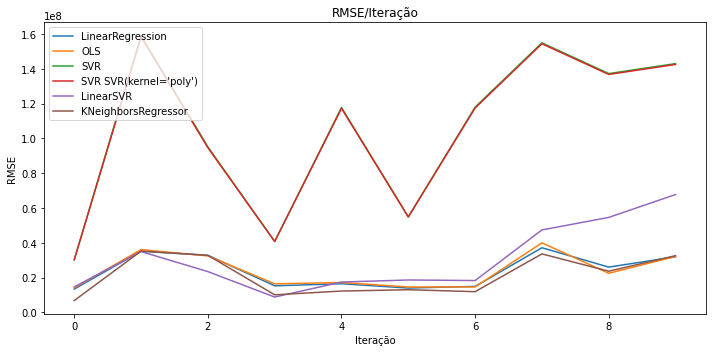

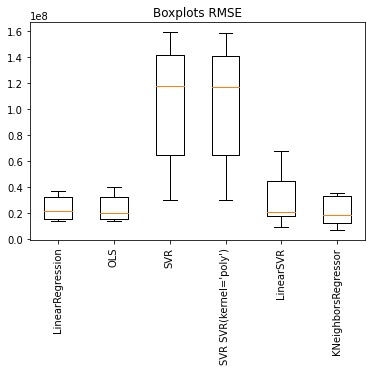

In [ ]:
plota_metrica(resp_10_random_fold, modelos, rmse, 'RMSE/Iteração', 'Iteração', 'RMSE', loc='upper left')

LinearRegression [[0, 1.230431843998861], [1, 1.3863759178577337], [2, 1.609484371928816], [3, 1.471346680406274], [4, 1.2729013747509013], [5, 1.6744176658937093], [6, 1.2754158224797596], [7, 0.5112477116220401], [8, 1.5564377401649825], [9, 1.4428492900931789]]
OLS [[0, 0.4861915431801641], [1, 0.44471956338642876], [2, 0.3613456477422591], [3, 0.45986209543392625], [4, 0.48982640294255014], [5, 0.4123488861376827], [6, 0.4852537897399149], [7, 0.4058714704470398], [8, 0.5416730063981], [9, 0.6233211823955331]]
SVR [[0, 1.1053723122072143], [1, 1.1020529441894462], [2, 1.2728862091367057], [3, 1.29902096600486], [4, 1.0714950153780072], [5, 1.3824536348321659], [6, 1.033127751702215], [7, 0.8010016696837705], [8, 1.1695872730679577], [9, 1.1700780098789256]]
SVR SVR(kernel='poly') [[0, 1.1053631145005234], [1, 1.1018811076835218], [2, 1.2727992880890813], [3, 1.2990070951549932], [4, 1.0714146162361933], [5, 1.3824398802139515], [6, 1.033054787566536], [7, 0.8009391596101583], [8, 1

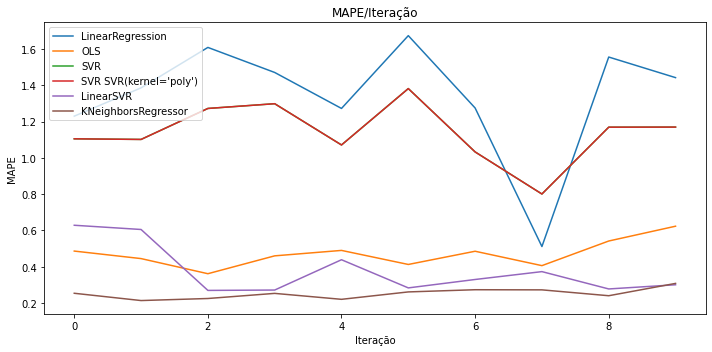

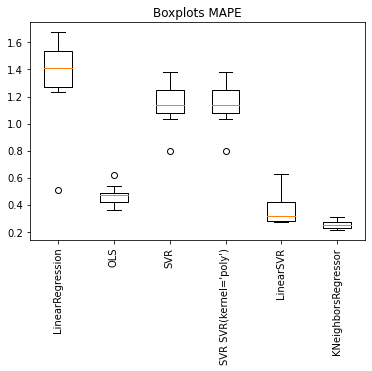

In [ ]:
plota_metrica(resp_10_random_fold, modelos, mean_absolute_percentage_error, 'MAPE/Iteração', 'Iteração', 'MAPE', loc='upper left')

LinearRegression [[0, 0.7731695887958835], [1, 0.9489000636343143], [2, 0.873492000940917], [3, 0.8309516848636744], [4, 0.9797166676482776], [5, 0.9225856064065694], [6, 0.9830007064395163], [7, 0.9397417576202485], [8, 0.9627584875510308], [9, 0.9485768062414541]]
OLS [[0, 0.7490364100417731], [1, 0.9462294240252432], [2, 0.8762028264066012], [3, 0.805486535298263], [4, 0.9779133138265047], [5, 0.9156180416661845], [6, 0.9837481022916728], [7, 0.9302819628401675], [8, 0.9722381540980937], [9, 0.9479169738567352]]
SVR [[0, -0.15820500929246228], [1, -0.045870763704449535], [2, -0.06404610693584667], [3, -0.20329822926015795], [4, -0.04077231992436281], [5, -0.1938498531634203], [6, -0.0616770728642313], [7, -0.04812728997498472], [8, -0.0374878267772345], [9, -0.030880817717983122]]
SVR SVR(kernel='poly') [[0, -0.15783572059961215], [1, -0.034475544540327085], [2, -0.05328569469440403], [3, -0.2029189137790779], [4, -0.031440581530334466], [5, -0.1935786982262626], [6, -0.052979138824

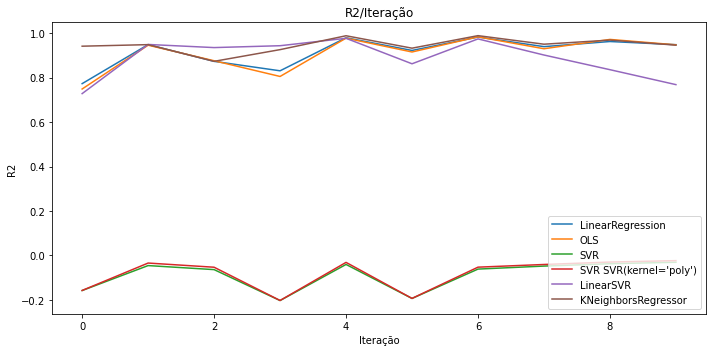

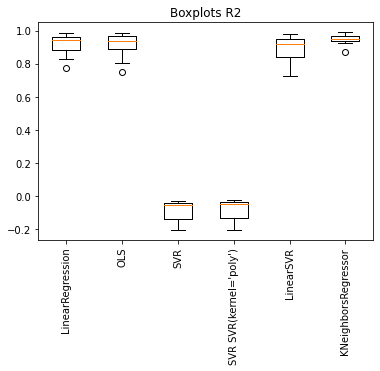

In [ ]:
plota_metrica(resp_10_random_fold, modelos, r2_score, 'R2/Iteração', 'Iteração', 'R2', loc='lower right')

Agora com 8 folds.

In [ ]:
resp_8_random_fold = treino_kfold(X_train, y_train, modelos, n_split=8, shuffle=True)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

LinearRegression [[0, 436339275429466.5], [1, 922297163634280.9], [2, 921275962975061.8], [3, 371763064136086.94], [4, 199436147140200.12], [5, 1150948607597580.8], [6, 177046529935879.66], [7, 1621337450929488.0]]
OLS [[0, 429115158124454.25], [1, 982177731937673.8], [2, 928624413964610.6], [3, 410685090026723.56], [4, 205116528501437.88], [5, 1326591148273302.2], [6, 163964463848663.53], [7, 1482594727568183.0]]
SVR [[0, 1.4707763388417608e+16], [1, 6606005895303919.0], [2, 8140037172220687.0], [3, 1.139167942791512e+16], [4, 2768092737955950.5], [5, 2.8575507247527524e+16], [6, 1892924580268367.0], [7, 3.04174495560502e+16]]
SVR SVR(kernel='poly') [[0, 1.4607189311892146e+16], [1, 6542373659191414.0], [2, 8069823680021512.0], [3, 1.1297545840537678e+16], [4, 2767543046560537.5], [5, 2.831851639715945e+16], [6, 1892497593140336.2], [7, 3.0158326045422764e+16]]
LinearSVR [[0, 4034906001758820.0], [1, 751148959630904.9], [2, 516741312224234.8], [3, 531643307991100.06], [4, 135451345567

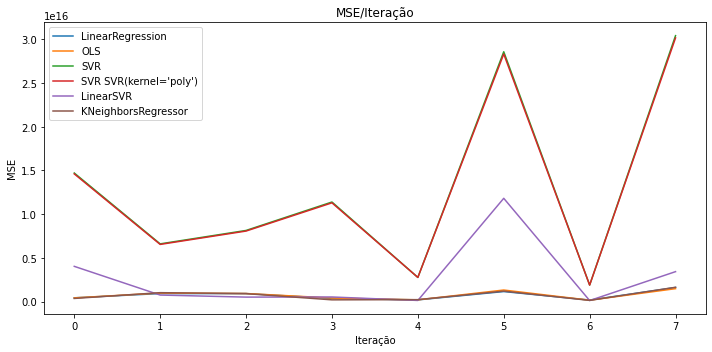

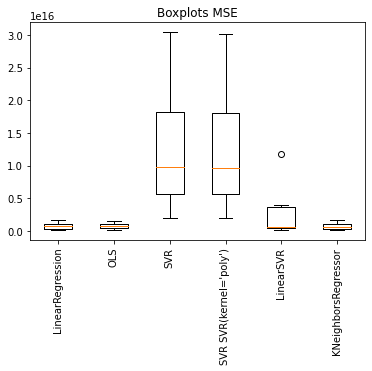

In [ ]:
plota_metrica(resp_8_random_fold, modelos, mean_squared_error, 'MSE/Iteração', 'Iteração', 'MSE', loc='upper left')

LinearRegression [[0, 20888735.61107676], [1, 30369345.78871071], [2, 30352528.11505265], [3, 19281158.267492305], [4, 14122186.344196146], [5, 33925633.48852281], [6, 13305883.282814398], [7, 40265834.78495743]]
OLS [[0, 20715094.933995698], [1, 31339714.930702128], [2, 30473339.396341365], [3, 20265366.762699448], [4, 14321889.836939743], [5, 36422398.99118813], [6, 12804860.946088541], [7, 38504476.72113183]]
SVR [[0, 121275567.97812825], [1, 81277339.37146269], [2, 90222154.55319545], [3, 106731810.75909431], [4, 52612667.08651017], [5, 169042915.40176275], [6, 43507753.105261214], [7, 174405990.59679744]]
SVR SVR(kernel='poly') [[0, 120860205.6588195], [1, 80884940.86782418], [2, 89832197.34606023], [3, 106289914.10542054], [4, 52607442.88178753], [5, 168281063.6915498], [6, 43502845.80507735], [7, 173661527.24602753]]
LinearSVR [[0, 63520909.95694898], [1, 27407096.884400304], [2, 22731944.752357524], [3, 23057391.612910166], [4, 11638356.652346762], [5, 108696155.31667744], [6, 

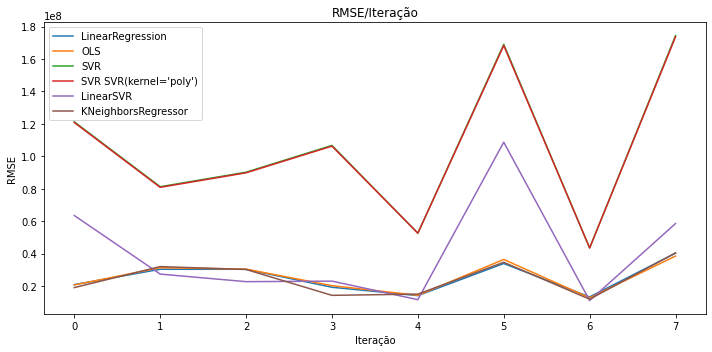

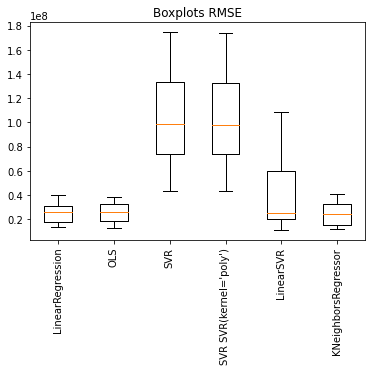

In [ ]:
plota_metrica(resp_8_random_fold, modelos, rmse, 'RMSE/Iteração', 'Iteração', 'RMSE', loc='upper left')

LinearRegression [[0, 1.2605986807064276], [1, 1.5637698080436697], [2, 1.4288507244987436], [3, 1.2877577406581484], [4, 1.7223225880112967], [5, 0.649416199557568], [6, 1.1577227423386818], [7, 1.6452041758264553]]
OLS [[0, 0.497708221948783], [1, 0.41690953543467535], [2, 0.38964814094484856], [3, 0.5046146961259315], [4, 0.42843730058495166], [5, 0.3343885677331208], [6, 0.5605143619135373], [7, 0.7441794672485827]]
SVR [[0, 1.091525919550588], [1, 1.2519331641683318], [2, 1.204052654430522], [3, 1.110720837095797], [4, 1.3531964429095076], [5, 0.9545310373203132], [6, 0.9534074091336467], [7, 1.234542208463292]]
SVR SVR(kernel='poly') [[0, 1.091476958529188], [1, 1.2518707005517016], [2, 1.2039797863471158], [3, 1.1106554301054345], [4, 1.3531868834072298], [5, 0.954416335192672], [6, 0.9533983606167782], [7, 1.234438364631276]]
LinearSVR [[0, 0.3124355193136341], [1, 0.43652025637407166], [2, 0.686508944025559], [3, 0.2702554748198824], [4, 0.4309644238036913], [5, 0.306331725963

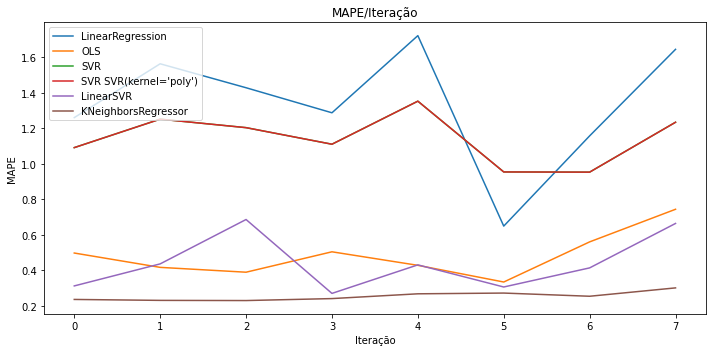

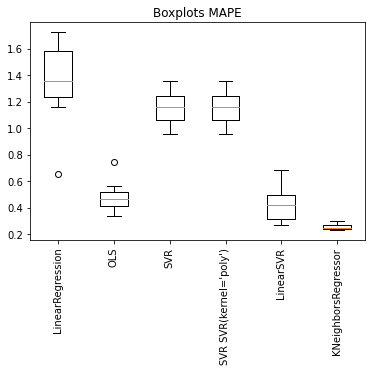

In [ ]:
plota_metrica(resp_8_random_fold, modelos, mean_absolute_percentage_error, 'MAPE/Iteração', 'Iteração', 'MAPE', loc='upper left')

LinearRegression [[0, 0.9692171502935438], [1, 0.8552737502566086], [2, 0.8762173718038856], [3, 0.9659032550323571], [4, 0.9163197075396787], [5, 0.9576269701670925], [6, 0.8874019088205073], [7, 0.9448578809147286]]
OLS [[0, 0.9697267970977265], [1, 0.8458773318084549], [2, 0.8752300340102029], [3, 0.9623334695468059], [4, 0.9139363082391478], [5, 0.9511605592718962], [6, 0.8957218440976233], [7, 0.949576557936232]]
SVR [[0, -0.037602836595818534], [1, -0.03660999589626712], [2, -0.09369530443161933], [3, -0.044803063234334806], [4, -0.1614484795808362], [5, -0.052028572863353384], [6, -0.20386259229227854], [7, -0.03450557114337749]]
SVR SVR(kernel='poly') [[0, -0.0305075397559873], [1, -0.02662486826228405], [2, -0.08426142039629214], [3, -0.03616947579294494], [4, -0.16121783765663822], [5, -0.04256726338563399], [6, -0.20359103692436542], [7, -0.025692711443738858]]
LinearSVR [[0, 0.7153455761928137], [1, 0.8821302111592114], [2, 0.9305706430046562], [3, 0.9512396253553287], [4, 

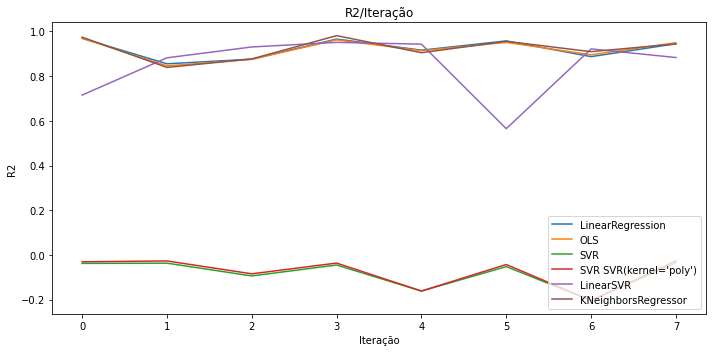

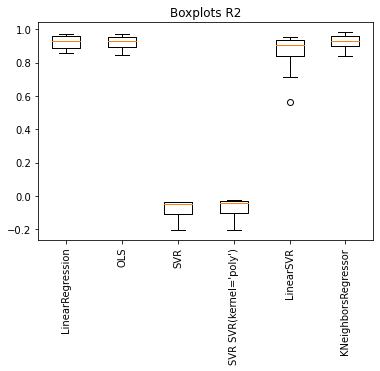

In [ ]:
plota_metrica(resp_8_random_fold, modelos, r2_score, 'R2/Iteração', 'Iteração', 'R2', loc='lower right')

Avaliando os gráficos dos resultados usando 10 e 8 folds, podemos observar o seguinte:

- Os modelos Linear Regression, OLS, KNR e SVR linear continuaram superiores aos SVR com kernels rbf e polinomial; 
- No R2, os modelos Linear Regression, OLS, KNR e SVR linear melhoraram se aproximando de 1; 
- O modelo SVR linear demonstrou ser mais sensível a quantidade e qualidade dos dados. Observe que os resultados do SVR linear variam bem mais que os modelos Linear Regression e KNR quando usamos 10 folds, o que implica mais dados de treinamento a cada iteração.

Vamos optar por realizar a avaliação com teste de hipótese das diferenças entre os modelos usando o 8-Fold Cross Validation aleatório.

## Teste de Hipóteses

Apesar de criarmos diferentes gráficos e computar diferentes métricas, para afirmarmos que um modelo é melhor que outro precisamos realizar um teste de hipótese. Vamos realizar o teste de hipótese com o auxílio da biblioteca [autorank](https://https://github.com/sherbold/autorank), a partir da métricas MSE calculadas com o 8-Fold Cross Validation aleatório.

In [ ]:
from autorank import autorank, plot_stats, create_report, latex_table

resp_dict = {}
for nome_modelo in modelos:  
  modelo = resp_8_random_fold[str(nome_modelo)]
  resp = []
  for i, d in enumerate(zip(modelo['reais'], modelo['preditos'])):
    real , predito = d
    resp.append(mean_squared_error(real, predito))
  resp_dict[nome_display_modelo(str(nome_modelo))] = resp


result = autorank(pd.DataFrame.from_dict(resp_dict), alpha=0.05, verbose=False)
create_report(result)

The statistical analysis was conducted for 6 populations with 8 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the population LinearRegression (p=0.002). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and one of them is not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is greater than the critical distance CD=2.666 of the Nemenyi test.
We reject the null hypothesis (p=0.000) of the Friedman test that there is no differe

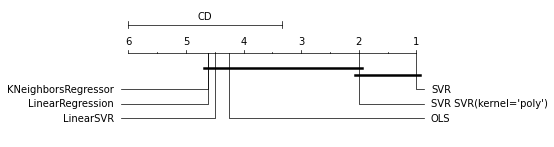

In [ ]:
plot_stats(result)
plt.show()

## Avaliação em dados de Testes

Nesse passo dos experimentos, os modelos escolhidos serão treinados em todo o corpo de treinamento e avaliados sobre os dados de testes.

In [ ]:
X_test = teste[['BPC','FPM','BOLSA FAMILIA']].values
y_test = teste[['AUXILIO EMERGENCIAL']].values

modelos = [LinearRegression(), OLSWrapper(), LinearSVR(max_iter=1000), KNeighborsRegressor(n_neighbors=5)]

resp_teste = {}
for modelo in modelos:
  if str(modelo) not in resp_teste.keys():
    resp_teste[str(modelo)] = {'preditos': None, 'reais': None}
  
  modelo.fit(X_train, y_train.ravel())
  y_predict = modelo.predict(X_test)

  resp_teste[str(modelo)]['preditos'] = y_predict.ravel()
  resp_teste[str(modelo)]['reais'] = y_test.ravel()
  resp_teste[str(modelo)]['modelo'] = modelo

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
def plota_metrica_teste(resultados, modelos, metrica, titulo, eixo_x, eixo_y, loc='upper left'):
  resp = []
  fig = plt.figure(figsize=(10, 5))
  plt.subplot(1, 1, 1)
  
  boxplots_data = []
  boxplots_ticks = []

  for nome_modelo in modelos:  
    modelo = resultados[str(nome_modelo)]
    nome_display = nome_display_modelo(str(nome_modelo))
    resp.append([nome_display, metrica(modelo['reais'], modelo['preditos'])])

  plt.bar([x[0] for x in resp], [x[1] for x in resp], color ='blue',
        width = 0.4)
 
  plt.title(titulo)
  plt.xlabel(eixo_x)
  plt.ylabel(eixo_y)
  fig.tight_layout()
  plt.show()

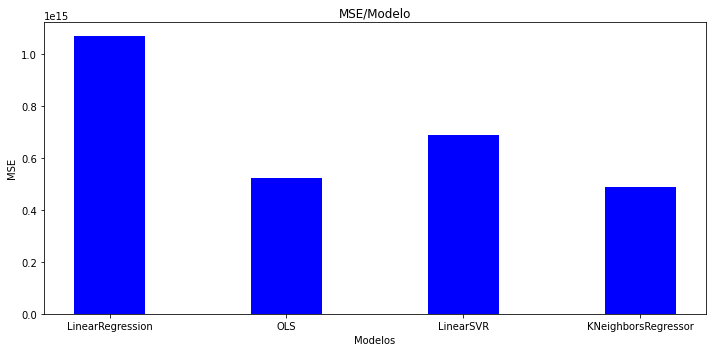

In [ ]:
plota_metrica_teste(resp_teste, modelos, mean_squared_error, 'MSE/Modelo', 'Modelos', 'MSE', loc='lower right')

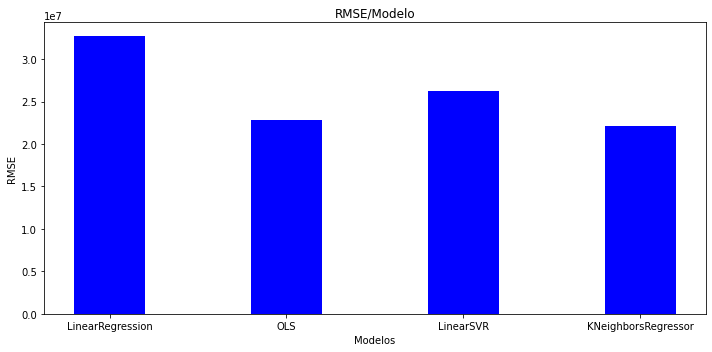

In [ ]:
plota_metrica_teste(resp_teste, modelos, rmse, 'RMSE/Modelo', 'Modelos', 'RMSE', loc='lower right')

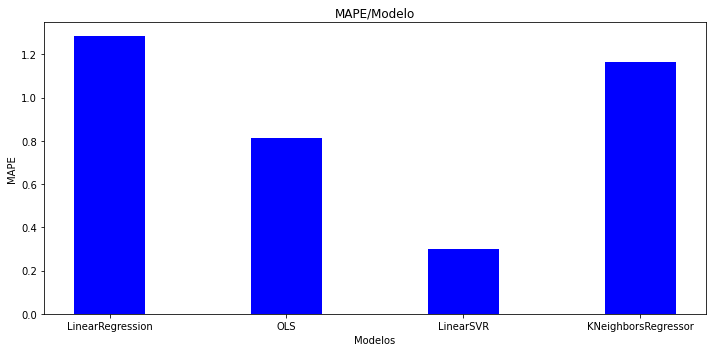

In [ ]:
plota_metrica_teste(resp_teste, modelos, mean_absolute_percentage_error, 'MAPE/Modelo', 'Modelos', 'MAPE', loc='lower right')

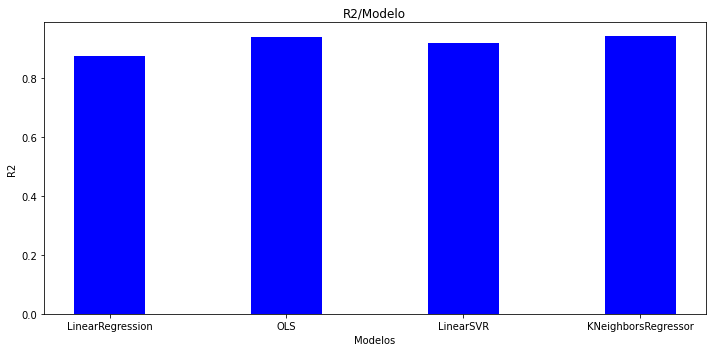

In [ ]:
plota_metrica_teste(resp_teste, modelos, r2_score, 'R2/Modelo', 'Modelos', 'R2', loc='lower right')

In [ ]:
def plota_real_predito(dados_modelo, nome_modelo):
  fig = plt.figure(figsize=(20, 10))
  plt.subplot(1, 1, 1)
  plt.plot(teste['Município'], modelo['reais'],
          label='Real')
  plt.plot(teste['Município'], modelo['preditos'],
          label='Predito')
  plt.title(nome_modelo)
  plt.legend(loc='upper right')
  plt.xlabel('Municípios')
  plt.xticks(rotation='90')
  plt.ylabel('Auxílio Emergencial')
  fig.tight_layout()
  plt.show()

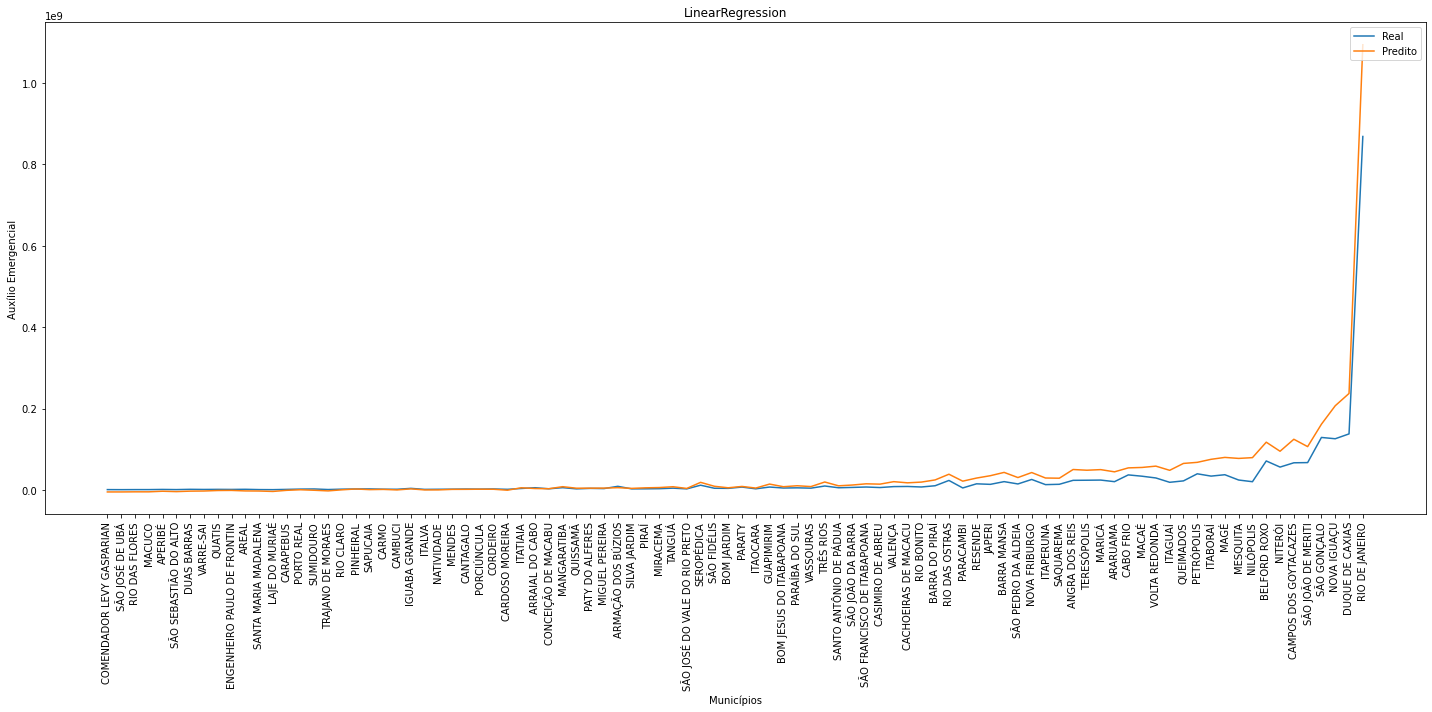

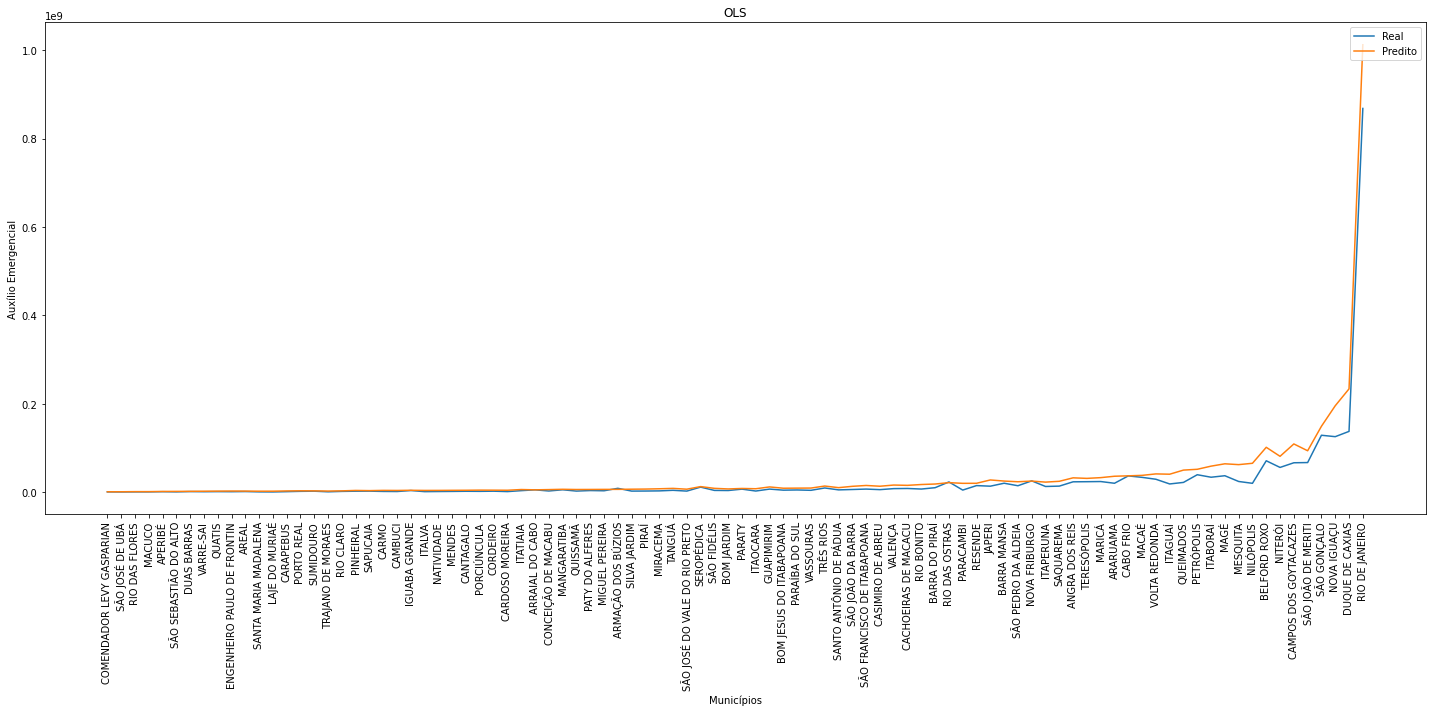

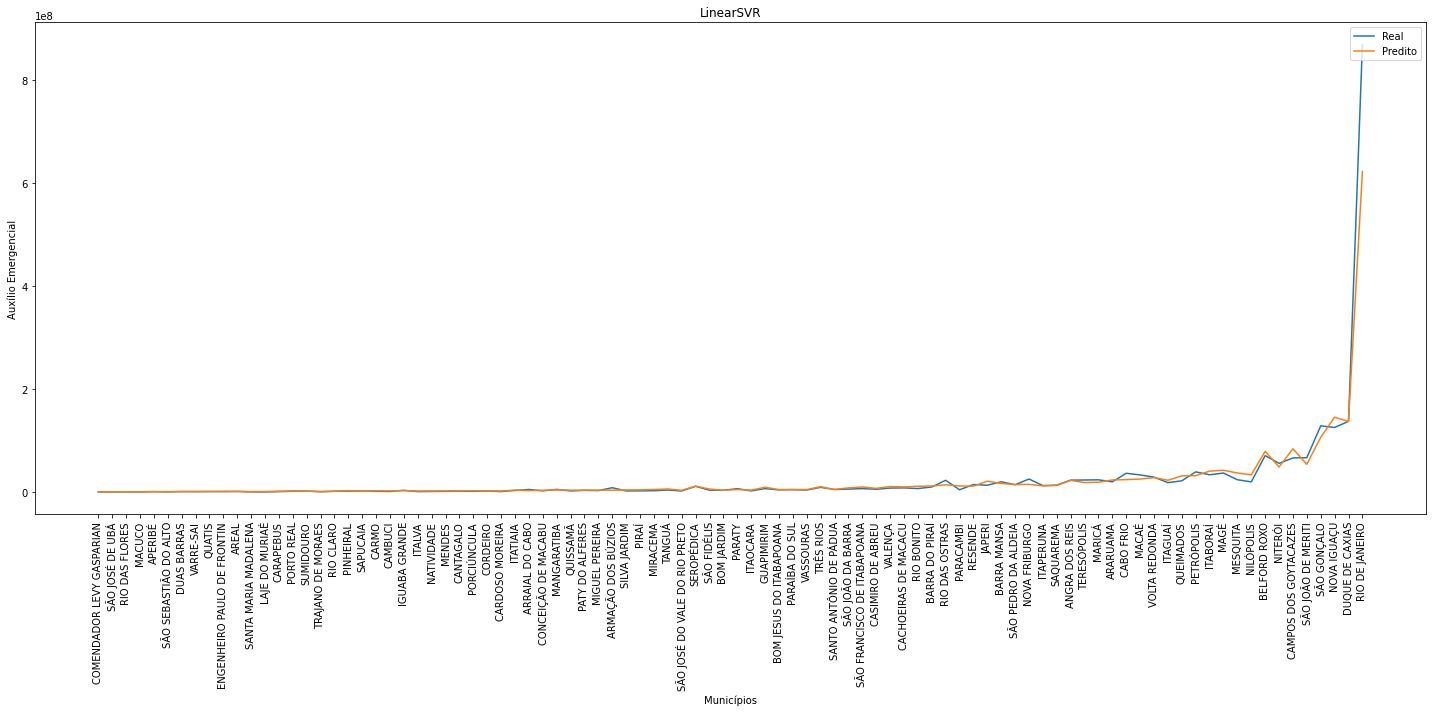

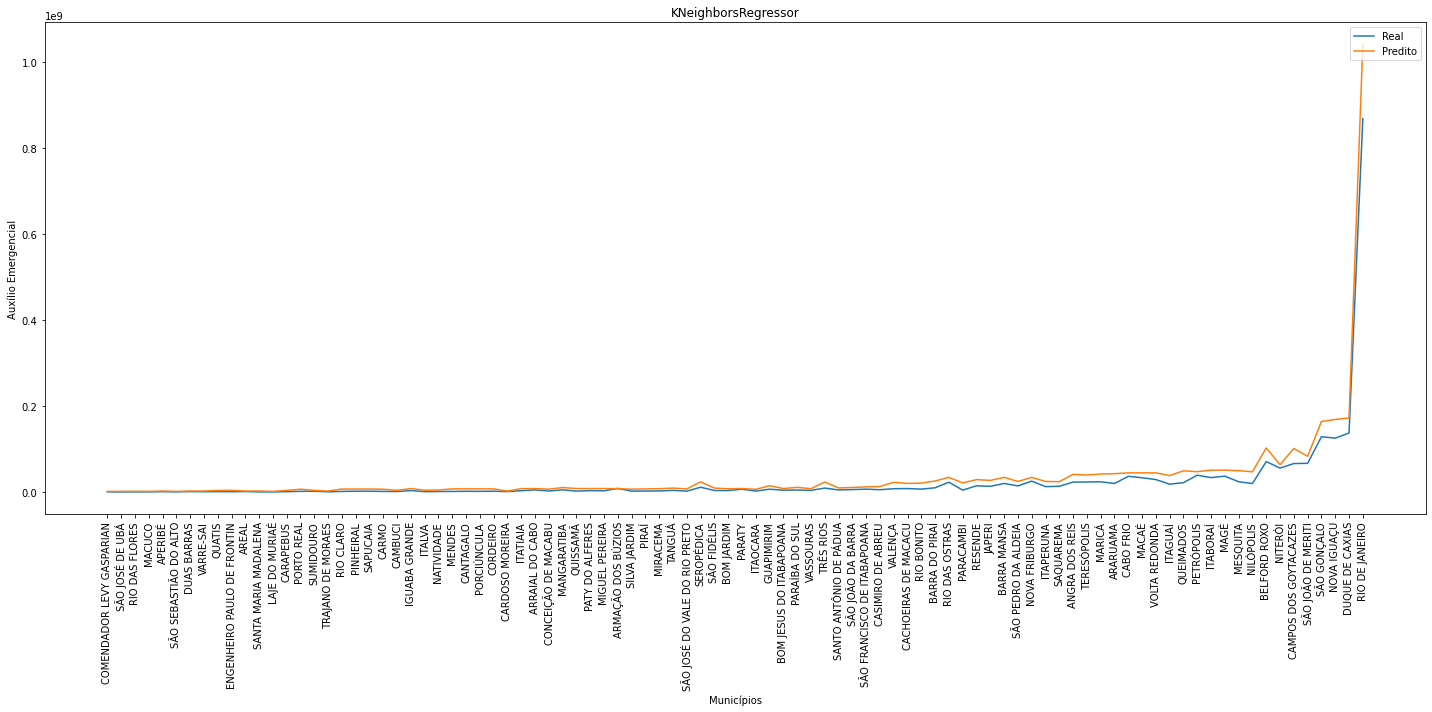

In [ ]:
for nome_modelo in modelos:  
  modelo = resp_teste[str(nome_modelo)]
  nome_display = nome_display_modelo(str(nome_modelo))
  plota_real_predito(resp_teste[str(nome_modelo)], nome_display)

## Análise do OLS induzido com todo o conjunto de treinamento

In [ ]:
resp_teste['OLS']['modelo'].model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                              5591.
Date:                Mon, 26 Jul 2021   Prob (F-statistic):                        0.00
Time:                        14:38:39   Log-Likelihood:                         -13543.
No. Observations:                 736   AIC:                                  2.709e+04
Df Residuals:                     733   BIC:                                  2.710e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             6.9257      0.290     23.901      0.000       6.357       7.495
x2             0.2822      0.498      0.567      0.571      -0.695       1.259
x3             3.6995      0.683      5.420      0.000       2.359       5.040
==============================================================================
Omnibus:                      380.990   Durbin-Watson:                   1.700
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           185962.733
Skew:                           0.938   Prob(JB):                         0.00
Kurtosis:                      80.849   Cond. No.                         12.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

A partir da tabela anterior, temos que os valores de coeficiente obtidos pela Regressão Linear com o modelo OLS do **statsmodel** assim como seus respectivos p-valores são:

<table>
<thead>
<th>Coeficiente</th>
<th>Mapeamento</th>
<th>Valor</th>
<th>p-valor</th>
<tbody>
<tr>
<td>x1</td>
<td>BPC</td>
<td>6.9257</td>
<td>0.000</td>
</tr>
<tr>
<td>x2</td>
<td>FPM</td>
<td>0.2822</td>
<td>0.571</td>
</tr>
<tr>
<td>x3</td>
<td>BOLSA FAMILIA</td>
<td>3.6995</td>
<td>0.000</td>
</tr>
</tbody>
</thead>
<table>

Analisando os dados destacados pela tabela acima, percebemos que os valores de **FPM** não são significativos para o modelo pois possui um p-valor > 5%. Neste caso, o ideal a ser feito é induzir novamente o modelo sem essa variável.

In [ ]:
X_train_sem_fpm = np.delete(X_train, [1], axis=1)
X_test_sem_fpm = np.delete(X_test, [1], axis=1)
modelo = OLSWrapper()
modelo.fit(X_train_sem_fpm, y_train.ravel())
y_predict = modelo.predict(X_test_sem_fpm)

ols_pred = y_predict.ravel()
ols_real = y_test.ravel()

modelo.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                              8394.
Date:                Mon, 26 Jul 2021   Prob (F-statistic):                        0.00
Time:                        14:38:45   Log-Likelihood:                         -13543.
No. Observations:                 736   AIC:                                  2.709e+04
Df Residuals:                     734   BIC:                                  2.710e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             6.9475      0.287     24.201      0.000       6.384       7.511
x2             3.7869      0.665      5.698      0.000       2.482       5.092
==============================================================================
Omnibus:                      372.047   Durbin-Watson:                   1.704
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           189130.674
Skew:                           0.866   Prob(JB):                         0.00
Kurtosis:                      81.513   Cond. No.                         11.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

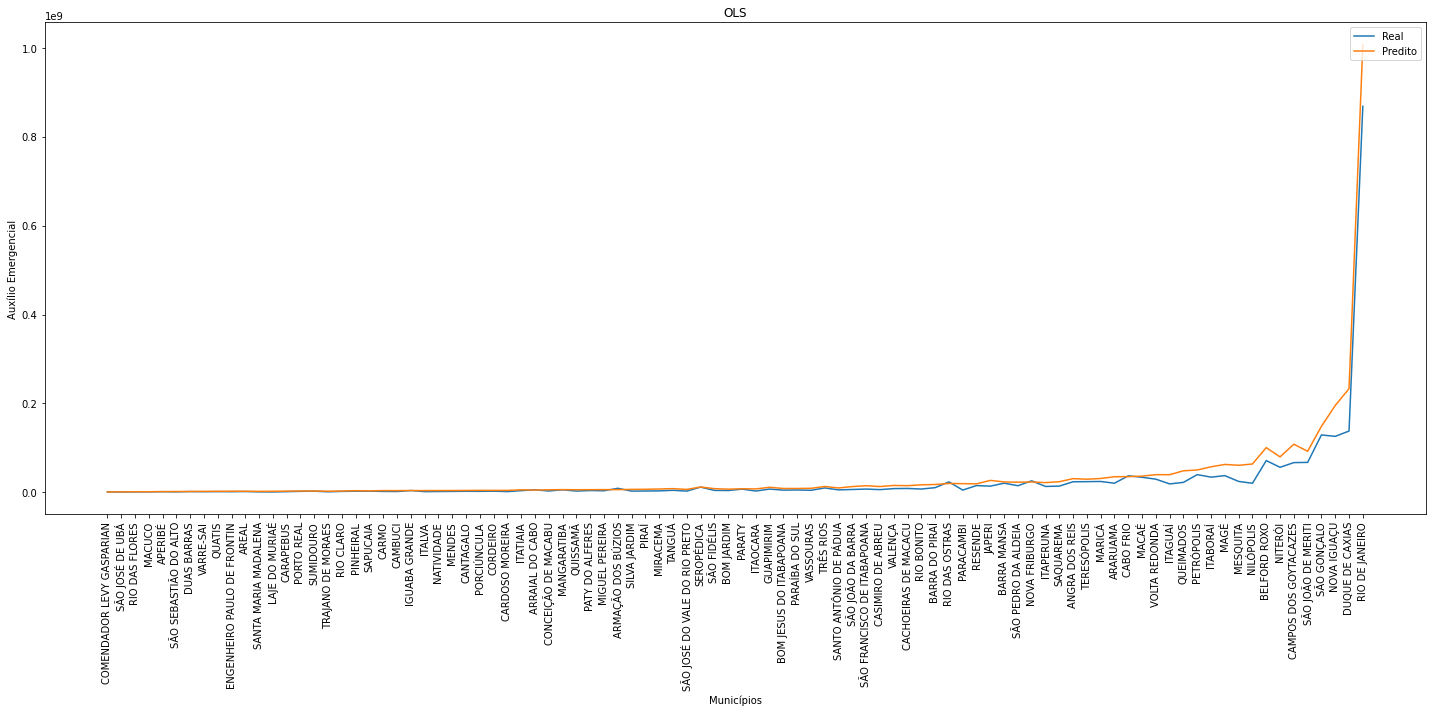

In [ ]:
fig = plt.figure(figsize=(20, 10))
plt.subplot(1, 1, 1)
plt.plot(teste['Município'], ols_real,
        label='Real')
plt.plot(teste['Município'], ols_pred,
        label='Predito')
plt.title('OLS')
plt.legend(loc='upper right')
plt.xlabel('Municípios')
plt.xticks(rotation='90')
plt.ylabel('Auxílio Emergencial')
fig.tight_layout()
plt.show()

Note que os valores dos coeficientes foram levemente alterados. Daí podemos escrever a função de regressão induzida pelo modelo como:

<a href="https://www.codecogs.com/eqnedit.php?latex=AUXILIO\_EMERGENCIAL&space;=&space;6.9475&space;\cdot&space;BPC&space;&plus;&space;3.7869\cdot&space;BOLSA\_FAMILIA" target="_blank"><img src="https://latex.codecogs.com/gif.latex?AUXILIO\_EMERGENCIAL&space;=&space;6.9475&space;\cdot&space;BPC&space;&plus;&space;3.7869\cdot&space;BOLSA\_FAMILIA" title="AUXILIO\_EMERGENCIAL = 6.9475 \cdot BPC + 3.7869\cdot BOLSA\_FAMILIA" /></a>

<!-- https://www.codecogs.com/latex/eqneditor.php -->

## Análise do modelo de regressão induzido com o Linear Regression do sklearn


In [ ]:
print('Coeficientes: ', resp_teste['LinearRegression()']['modelo'].coef_)
print('Constante: ', resp_teste['LinearRegression()']['modelo'].intercept_)

Coeficientes:  [6.25515798 3.81634711 4.03283863]
Constante:  -9182542.084970292


<a href="https://www.codecogs.com/eqnedit.php?latex=AUXILIO\_EMERGENCIAL&space;=&space;6.25515798&space;\cdot&space;BPC&space;&plus;&space;3.81634711&space;\cdot&space;FPM&space;&plus;&space;4.03283863&space;\cdot&space;BOLSA\_FAMILIA-9182542.084970292" target="_blank"><img src="https://latex.codecogs.com/png.latex?AUXILIO\_EMERGENCIAL&space;=&space;6.25515798&space;\cdot&space;BPC&space;&plus;&space;3.81634711&space;\cdot&space;FPM&space;&plus;&space;4.03283863&space;\cdot&space;BOLSA\_FAMILIA-9182542.084970292" title="AUXILIO\_EMERGENCIAL = 6.25515798 \cdot BPC + 3.81634711 \cdot FPM + 4.03283863 \cdot BOLSA\_FAMILIA-9182542.084970292" /></a>

É interessante notar que o coeficiente relativo ao BPC manteve a mesma faixa de valor quando comparado ao valor obtido com o OLS do statsmodel. 
Enquanto isso, o coeficiente relativo ao BOLSA FAMILIA teve sua diferença menor que a diferença entre o BPC deste modelo para o modelo do OLS.
Por fim, cabe ressaltar que o uso da variável FPM com um valor significativo resultou na adição de uma constante negativa de grande ordem.

## Análise do SVR

In [ ]:
modelo = resp_teste['LinearSVR()']['modelo']
print('Coeficientes: ', modelo.coef_)
print('Constante: ', modelo.intercept_)

Coeficientes:  [2.9541171  0.18973131 5.49698597]
Constante:  [-0.09984315]


<a href="https://www.codecogs.com/eqnedit.php?latex=AUXILIO\_EMERGENCIAL&space;=&space;1.02850565&space;\cdot&space;BPC&space;&plus;&space;0.44230761&space;\cdot&space;FPM&space;&plus;&space;4.26802729&space;\cdot&space;BOLSA\_FAMILIA-0.09803584" target="_blank"><img src="https://latex.codecogs.com/gif.latex?AUXILIO\_EMERGENCIAL&space;=&space;1.02850565&space;\cdot&space;BPC&space;&plus;&space;0.44230761&space;\cdot&space;FPM&space;&plus;&space;4.26802729&space;\cdot&space;BOLSA\_FAMILIA-0.09803584" title="AUXILIO\_EMERGENCIAL = 1.02850565 \cdot BPC + 0.44230761 \cdot FPM + 4.26802729 \cdot BOLSA\_FAMILIA-0.09803584" /></a>

Note como a função de regressão induzida pelo Linear SVR dá mais peso para o BOLSA_FAMILIA, diminuindo significativamente o peso do BPC, o que reflete numa constante negativa bem menor tmabém.